Base repo of data: https://github.com/mlsedigital/SPL-open-data

Great xyz data dict: https://www.inpredictable.com/2021/01/nba-player-shooting-motions-data-dump.html


## Ultimate Goals:
* Find optimal shooting form/release point
  * Include the feedback system based on optimal shooting form and release point
  * ### Use shooting meter from NBA 2k to show good vs bad releases and body movements
  * ^use the motions that:
    * produce good results (a make or enough kinetic energy for a near make)
    * are within certain boundaries where the player is comfortable AND in right shooting form
    * are within certain ranges (this inch to this inch is the best motion area for this player, etc.)
    * Compared to Popular Shooters to make recommendations to shoot more like someone like Klay Thompson or Buddy Hield (see if the data from the xyz data dictionary has good shooters to make recommendations to shoot like them)
* Exhaustion levels and optimal energy max and min
* Shot outcome prediction


1. Finding Optimal Shooting Form/Release Point

    Detailed Analysis of Body Movements: Include analysis of body kinematics (positions and velocities of limbs) at the time of release. Use joint coordinates to extract features like elbow angle, shoulder rotation, and wrist flexion at the release frame.
    Machine Learning for Form Classification: Train a model to classify "good" vs. "bad" shooting forms using successful shot data (makes or near-makes) and compare them against unsuccessful shots.
    Feedback Mechanism: Implement a feedback system that suggests adjustments based on the comparison of current shooting mechanics to historical optimal ones.

2. Shooting Meter Simulation (NBA 2K-Style)

    Visual Feedback System: Develop a visualization tool that overlays a “meter” on shot video frames, indicating the quality of the release in real-time. This can be based on a scoring function derived from the shooting form features and ball dynamics.
    Comfort Zone Identification: Use clustering algorithms (e.g., K-means) to identify comfortable ranges of motion based on historical shooting data for individual players.

3. Shot Outcome Prediction

    Feature Engineering for Outcome Modeling: Include additional features such as:
        Kinetic Energy Calculation: KE=12mv2KE=21​mv2 to see if the ball had sufficient energy for a make.
        Entry Angle and Trajectory Analysis: Analyze whether the angle at which the ball approaches the hoop aligns with optimal scoring trajectories.
    Model Development: Build a machine learning model (e.g., logistic regression, XGBoost) that predicts shot outcomes based on ball speed, entry angle, release point, and body dynamics.
    Training with Data Augmentation: Use synthetic data generation to include a wide variety of shot scenarios.

4. Exhaustion Levels and Energy Management

    Tracking Player Movements: Use the coordinates of major joints (e.g., knees, hips) to estimate a player's exertion level using metrics like the average vertical displacement over time.
    Velocity and Acceleration Patterns: Monitor changes in the velocity and acceleration of the player's body parts throughout a game to detect fatigue.
    Feature Integration: Create features such as average speed and distance covered leading up to the shot to include in the predictive model.

5. shot simulator: 
    if by these metrics we can simulate the shot to a nearby hoop. We can set the hoop in a set location (or when using spatial, we'd pick the location), and set it up to virtualize the experience with yolo/opencv where when you make those motions to show shooting motion, you can show where the ball might go (even without a ball in hand).

# ML Dataset Pipeline:
    - categorize data
    - multicollinearity/feature importances = feature selection
    - preprocessing suggestions, datasets, preprocessing with strict guidelines
    - ml model selection
    - ml model testing
    - ml data inverse transform
    - ml model prediction
    - live prediction and re-calculate the dataset formulas for when new data attaches
    - get optimal ranges for the angles (knee/wrist/elbow) and input them into the meters
    - input the meters into a video for optimal angles
    - add in ml classification with re-calculation
    - live camera feed with this? 
      - streamlit example of how this works with li


In [79]:
# %%writefile ../../src/freethrow_predictions/ml/categorize_categoricals.py
"""
Automated Categorization Module
This script automates the categorization of continuous variables into bins 
with specified labels and applies transformations to multiple columns.

To use:
1. Define a bin configuration dictionary with the desired bins and labels.
2. Pass your DataFrame and configuration to the `transform_features_with_bins` function.

Author: Your Name
"""

# Imports
import pandas as pd
import numpy as np
import pickle
import logging


# Function Definitions
def categorize_column(df, column_name, bins, labels, new_column_name=None, debug=False):
    """
    Categorizes a column into bins with specified labels.

    Args:
        df (DataFrame): The dataset to transform.
        column_name (str): Name of the column to bin.
        bins (list): Bin edges for categorization.
        labels (list): Labels corresponding to each bin.
        new_column_name (str): Optional; name of the new column. Defaults to "<column_name>_category".
        debug (bool): If True, prints debugging information.

    Returns:
        Series: The newly categorized column as a pandas Series.
    """
    try:
        if new_column_name is None:
            new_column_name = f"{column_name}_category"

        # Apply binning
        categorized_column = pd.cut(df[column_name], bins=bins, labels=labels)

        if debug:
            print(f"\nBinning applied to '{column_name}' -> New column: '{new_column_name}'")
            print(pd.DataFrame({column_name: df[column_name], new_column_name: categorized_column}).head())

        return categorized_column
    except KeyError:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return pd.Series(index=df.index)  # Return an empty series if the column is missing
    except Exception as e:
        print(f"Unexpected error while categorizing '{column_name}': {e}")
        return pd.Series(index=df.index)  # Return an empty series if there's an error


def transform_features_with_bins(df, bin_config, debug=False):
    """
    Applies binning transformations to multiple columns based on the provided configuration.

    Args:
        df (DataFrame): The dataset to transform.
        bin_config (dict): Configuration dictionary where keys are column names and values are
                           dictionaries with 'bins', 'labels', and optionally 'new_column_name'.
        debug (bool): If True, prints debugging information.

    Returns:
        DataFrame: A new DataFrame containing only the categorized columns.
    """
    categorized_df = pd.DataFrame(index=df.index)  # Initialize an empty DataFrame with the same index
    for column, config in bin_config.items():
        bins = config['bins']
        labels = config['labels']
        new_column_name = config.get('new_column_name', f"{column}_category")  # Default new column name
        categorized_df[new_column_name] = categorize_column(df, column, bins, labels, debug=debug)

    return categorized_df


if __name__ == "__main__":
    # Debugging mode
    debug = True

    # Example bin configuration
    category_bin_config = {
        'player_height_in_meters': {
            'bins': [0, 1.80, 2.00, np.inf],
            'labels': ["Short", "Average", "Tall"]
        },
        'player_weight__in_kg': {
            'bins': [0, 75, 95, np.inf],
            'labels': ["Lightweight", "Average", "Heavy"]
        },
        'player_estimated_wingspan_cm': {
            'bins': [0, 190, 220, np.inf],
            'labels': ["Small", "Medium", "Large"]
        },
        'player_estimated_standing_reach_cm': {
            'bins': [0, 230, 250, np.inf],
            'labels': ["Short", "Average", "Tall"]
        },
        'player_estimated_hand_length_cm': {
            'bins': [0, 20, 25, np.inf],
            'labels': ["Small", "Medium", "Large"]
        }
    }
    
    # Save the category bin configuration
    with open('../../data/default_spl_example/category_bin_config.pkl', 'wb') as f:
        pickle.dump(category_bin_config, f)

    # Load the category bin configuration
    with open('../../data/default_spl_example/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)

    # Step 1: Transform player features using the configuration
    categorized_columns_df = transform_features_with_bins(final_ml_df, loaded_category_bin_config, debug=debug)

    # Step 2: Combine the original DataFrame with the categorized columns
    final_ml_df_categoricals = pd.concat([final_ml_df, categorized_columns_df], axis=1)

    # Debugging output
    if debug:
        print("\nFinal DataFrame with Categorized Features:")
        print(final_ml_df_categoricals.columns)




Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [80]:
# %%writefile ../../src/freethrow_predictions/ml/smote_automation.py
import pandas as pd
import numpy as np
import pickle
import logging
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from collections import Counter
from imblearn.over_sampling import (
    BorderlineSMOTE,
    ADASYN,
    SMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

# Configure logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s [%(levelname)s] %(message)s',
                    handlers=[
                        logging.FileHandler("smote_analysis.log"),
                        logging.StreamHandler()
                    ])

def check_dataset_for_smote(dataset, y_variable, debug=False,
                            imbalance_threshold=0.2,
                            noise_threshold=0.5,
                            overlap_threshold=0.3,
                            boundary_threshold=0.4,
                            extreme_imbalance_threshold=0.05):
    """
    Analyzes a dataset to recommend the best SMOTE variant based on class imbalance,
    noise, and overlap characteristics.
    
    Parameters:
        dataset (pd.DataFrame): The input dataset.
        y_variable (str): The name of the target variable.
        debug (bool): Whether to log debug information.
        imbalance_threshold (float): Threshold for severe imbalance.
        noise_threshold (float): Threshold for noise detection.
        overlap_threshold (float): Threshold for class overlap detection.
        boundary_threshold (float): Threshold for boundary concentration detection.
        extreme_imbalance_threshold (float): Threshold for extreme imbalance.

    Returns:
        dict: Recommendations for the most suitable SMOTE variant(s).
    """
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("The dataset must be a pandas DataFrame.")
    if y_variable not in dataset.columns:
        raise ValueError(f"The target variable '{y_variable}' is not in the dataset.")

    # Step 1: Check class distribution
    y_counts = dataset[y_variable].value_counts()
    total_samples = len(dataset)
    class_distribution = y_counts / total_samples
    majority_class = class_distribution.idxmax()
    minority_class = class_distribution.idxmin()

    if debug:
        logging.debug(f"Dataset Shape: {dataset.shape}")
        logging.debug(f"Class Distribution: {class_distribution.to_dict()}")

    severe_imbalance = class_distribution[minority_class] < imbalance_threshold
    if class_distribution[minority_class] < extreme_imbalance_threshold:
        logging.warning(f"The dataset has extreme imbalance ({class_distribution[minority_class]:.2%}). SMOTE may not perform well.")

    # Step 2: Analyze noise using k-Nearest Neighbors (k=5)
    if debug:
        logging.debug("Analyzing noise using Nearest Neighbors")

    minority_samples = dataset[dataset[y_variable] == minority_class]
    majority_samples = dataset[dataset[y_variable] == majority_class]

    knn = NearestNeighbors(n_neighbors=5)
    try:
        knn.fit(majority_samples.drop(columns=[y_variable]))
        distances, _ = knn.kneighbors(minority_samples.drop(columns=[y_variable]))

        median_distance = np.median(distances)
        noise_ratio = np.mean(distances < median_distance)
        if debug:
            logging.debug(f"Median distance to nearest neighbors: {median_distance}")
            logging.debug(f"Noise Ratio (minority samples close to majority): {noise_ratio}")

        noisy_data = noise_ratio > noise_threshold  # Threshold for determining noise
        if noise_ratio > 0.9:
            logging.warning("High noise detected in the dataset. SMOTE may not be effective.")
    except ValueError as e:
        logging.error(f"Error during noise analysis: {e}")
        noisy_data = False

    # Step 3: Inspect class overlap
    if debug:
        logging.debug("Inspecting class overlap")

    try:
        pdistances = pairwise_distances(minority_samples.drop(columns=[y_variable]),
                                        majority_samples.drop(columns=[y_variable]))
        overlap_metric = np.mean(pdistances < 1.0)
        if debug:
            logging.debug(f"Overlap Metric (proportion of close samples): {overlap_metric}")

        overlapping_classes = overlap_metric > overlap_threshold  # Threshold for overlap
    except ValueError as e:
        logging.error(f"Error during class overlap analysis: {e}")
        overlapping_classes = False

    # Step 4: Detect boundary concentration
    if debug:
        logging.debug("Detecting boundary concentration")

    try:
        boundary_ratio = np.mean(np.min(distances, axis=1) < np.percentile(distances, 25))
        if debug:
            logging.debug(f"Boundary Concentration Ratio: {boundary_ratio}")

        boundary_concentration = boundary_ratio > boundary_threshold  # Threshold for boundary detection
    except Exception as e:
        logging.error(f"Error during boundary concentration analysis: {e}")
        boundary_concentration = False

    # Step 5: Recommend SMOTE variant
    recommendations = []
    if severe_imbalance:
        recommendations.append("ADASYN" if not noisy_data else "SMOTEENN")
    if noisy_data:
        recommendations.append("SMOTEENN")
    if overlapping_classes:
        recommendations.append("SMOTETomek")
    if boundary_concentration:
        recommendations.append("BorderlineSMOTE")

    if not recommendations:
        recommendations.append("SMOTE")

    if len(recommendations) > 1:
        logging.warning("Multiple SMOTE variants are recommended. Please select the most appropriate one.")

    if debug:
        logging.debug("Recommendations based on dataset analysis:")
        logging.debug(f"  - Severe Imbalance: {severe_imbalance}")
        logging.debug(f"  - Noisy Data: {noisy_data}")
        logging.debug(f"  - Overlapping Classes: {overlapping_classes}")
        logging.debug(f"  - Boundary Concentration: {boundary_concentration}")

    return {
        "recommendations": recommendations,
        "details": {
            "severe_imbalance": severe_imbalance,
            "noisy_data": noisy_data,
            "overlapping_classes": overlapping_classes,
            "boundary_concentration": boundary_concentration
        }
    }

def identify_non_numeric_columns(dataset, y_variable, debug=False):
    non_numeric_columns = dataset.drop(columns=[y_variable]).select_dtypes(exclude=[np.number]).columns
    if debug:
        logging.debug("Identified Non-Numeric Columns:")
        logging.debug(non_numeric_columns.tolist())
    return non_numeric_columns

def preprocess_smote_dataset(dataset, y_variable, debug=False):
    """
    Preprocesses the dataset by handling non-numeric columns and missing values.
    
    Parameters:
        dataset (pd.DataFrame): The input dataset.
        y_variable (str): The name of the target variable.
        debug (bool): Whether to log debug information.

    Returns:
        pd.DataFrame: A preprocessed dataset with only numeric features.
    """
    non_numeric_columns = identify_non_numeric_columns(dataset, y_variable, debug=debug)

    # Drop non-numeric columns for simplicity
    preprocessed_data = dataset.drop(columns=non_numeric_columns)
    
    if debug:
        logging.debug(f"Dataset Shape after dropping non-numeric columns: {preprocessed_data.shape}")

    # Check for missing values
    if preprocessed_data.isnull().sum().sum() > 0:
        preprocessed_data = preprocessed_data.fillna(preprocessed_data.mean())
        if debug:
            logging.debug("Filled Missing Values in Dataset")

    return preprocessed_data

def apply_smote(dataset, y_variable, recommendations, debug=False, smote_params=None):
    """
    Automatically applies the most suitable SMOTE variant based on recommendations.
    
    Parameters:
        dataset (pd.DataFrame): The input dataset.
        y_variable (str): The name of the target variable.
        recommendations (list): Recommended SMOTE variants.
        debug (bool): Whether to log debug information.
        smote_params (dict): Parameters for SMOTE variants.

    Returns:
        pd.DataFrame: Resampled dataset.
        str: The SMOTE variant used.
    """
    smote_technique = None
    X = dataset.drop(columns=[y_variable])
    y = dataset[y_variable]
    
    if smote_params is None:
        smote_params = {"random_state": 42}

    # Map recommendations to SMOTE classes
    smote_variants = {
        "ADASYN": ADASYN(**smote_params),
        "SMOTEENN": SMOTEENN(**smote_params),
        "SMOTETomek": SMOTETomek(**smote_params),
        "BorderlineSMOTE": BorderlineSMOTE(**smote_params),
        "SMOTE": SMOTE(**smote_params)
    }
    
    if len(recommendations) == 1:
        smote_technique = recommendations[0]
    else:
        # Prompt user to select if multiple recommendations exist
        logging.warning("Multiple SMOTE recommendations found:")
        for idx, rec in enumerate(recommendations):
            logging.info(f"{idx + 1}. {rec}")
        choice = int(input("Select the SMOTE technique to apply (1-N): ")) - 1
        smote_technique = recommendations[choice]
    
    if smote_technique not in smote_variants:
        raise ValueError(f"SMOTE variant '{smote_technique}' is not implemented.")
    
    smote_instance = smote_variants[smote_technique]
    try:
        X_resampled, y_resampled = smote_instance.fit_resample(X, y)
    except Exception as e:
        logging.error(f"Error during SMOTE application: {e}")
        raise

    resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                                   pd.Series(y_resampled, name=y_variable)], axis=1)
    
    if debug:
        logging.debug(f"Applied SMOTE Technique: {smote_technique}")
        logging.debug(f"Original Dataset Shape: {dataset.shape}")
        logging.debug(f"Resampled Dataset Shape: {resampled_dataset.shape}")
        logging.debug(f"Original Class Distribution: {Counter(y)}")
        logging.debug(f"Resampled Class Distribution: {Counter(y_resampled)}")

    return resampled_dataset, smote_technique

if __name__ == "__main__":
    y_variable = "result"
    debug = True
    # from categorize_categoricals import transform_features_with_bins

    # Load the category bin configuration
    with open('../../data/default_spl_example/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)

    # Step 1: Transform player features using the configuration
    categorized_columns_df = transform_features_with_bins(final_ml_df, loaded_category_bin_config, debug=False)

    # Step 2: Combine the original DataFrame with the categorized columns
    final_ml_df_categoricals = pd.concat([final_ml_df, categorized_columns_df], axis=1)

    # Preprocess dataset
    preprocessed_dataset = preprocess_smote_dataset(final_ml_df_categoricals, y_variable, debug=debug)

    # Perform SMOTE analysis
    smote_analysis = check_dataset_for_smote(preprocessed_dataset, y_variable, debug=debug)
    logging.info("Final Recommendations:")
    logging.info(smote_analysis)
    
    # Apply SMOTE based on recommendations
    final_ml_df_categoricals_smoted, smote_used = apply_smote(
        preprocessed_dataset,
        y_variable,
        smote_analysis["recommendations"],
        debug=debug
    )

    logging.info(f"SMOTE Technique Used: {smote_used}")
    logging.info(f"Resampled Dataset Shape: {final_ml_df_categoricals_smoted.shape}")



2024-11-27 17:42:54,350 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:54,351 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:54,352 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:54,354 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:54,354 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:54,355 [DEBUG] Analyzing noise using Nearest Neighbors
2024-11-27 17:42:54,360 [DEBUG] Median distance to nearest neighbors: 44.30014723451984
2024-11-27 17:42:54,361 [DEBUG] Noise Ratio (minority samples close to majority): 0.4972972972972973
2024-11-27 17:42:54,362 [DEBUG] Inspecting class overlap
2024-11-27 17:42:54,365 [DEBUG] Overlap Metric (proportion of close samples): 0.0
2024-11-27 17:42:

In [81]:
# %%writefile ../../src/freethrow_predictions/ml/feature_selection_multicollinearchk_importancechk.py
# Feature Selection: Check Multicollinearity, root out or combine, then check feature importance, root out or leave with extra feature information

import pandas as pd
import numpy as np
import pickle
import logging
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def check_multicollinearity(df, threshold=0.8, debug=False):
    """
    Identifies pairs of features with correlation above the specified threshold.
    Args:
        df (DataFrame): DataFrame containing numerical features.
        threshold (float): Correlation coefficient threshold.
        debug (bool): If True, prints debugging information.
    Returns:
        DataFrame: Pairs of features with high correlation.
    """
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if debug:
        print(f"Computing correlation matrix for {len(numeric_df.columns)} numerical features...")

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify highly correlated features
    highly_correlated = [
        (column, idx, upper.loc[column, idx])
        for column in upper.columns
        for idx in upper.index
        if (upper.loc[column, idx] > threshold)
    ]

    multicollinearity_df = pd.DataFrame(highly_correlated, columns=['Feature1', 'Feature2', 'Correlation'])

    if debug:
        if not multicollinearity_df.empty:
            print(f"Found {len(multicollinearity_df)} pairs of highly correlated features:")
            print(multicollinearity_df)
        else:
            print("No highly correlated feature pairs found.")

    return multicollinearity_df



def calculate_feature_importance(df, target_variable, n_estimators=100, random_state=42, debug=False):
    """
    Calculates feature importance using a Random Forest model.
    """
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    # Encode target variable if necessary
    if y.dtype == 'object' or str(y.dtype) == 'category':
        if debug:
            print(f"Target variable '{target_variable}' is categorical. Encoding labels.")
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Separate categorical and numerical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    if debug:
        print(f"Categorical columns in X: {categorical_cols}")
        print(f"Numeric columns in X: {numeric_cols}")

    # Encode categorical features if present
    if categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_encoded = ohe.fit_transform(X[categorical_cols])
        encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
        X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names, index=X.index)
        X = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

    # Select Random Forest model
    model = (
        RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        if y.dtype in ['int64', 'float64'] else
        RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    )

    if debug:
        print(f"Training model on {X.shape[1]} features and {len(y)} samples...")

    # Train the model
    model.fit(X, y)

    # Extract feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    if debug:
        print("\nFeature Importances:")
        print(feature_importances)

    return feature_importances




if __name__ == "__main__":
    # Load your dataset
    
    # from categorize_categoricals import transform_features_with_bins
    # from smote_automation import preprocess_smote_dataset, check_dataset_for_smote, apply_smote
    # Load the category bin configuration
    with open('../../data/default_spl_example/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)

    # Step 1: Transform player features using the configuration
    categorized_columns_df = transform_features_with_bins(final_ml_df, loaded_category_bin_config, debug=False)

    # Step 2: Combine the original DataFrame with the categorized columns
    final_ml_df_categoricals = pd.concat([final_ml_df, categorized_columns_df], axis=1)

    # Preprocess dataset
    preprocessed_dataset = preprocess_smote_dataset(final_ml_df_categoricals, y_variable, debug=False)

    # Perform SMOTE analysis
    smote_analysis = check_dataset_for_smote(preprocessed_dataset, y_variable, debug=False)
    logging.info("Final Recommendations:")
    logging.info(smote_analysis)
    
    # Apply SMOTE based on recommendations
    final_ml_df_categoricals_smoted, smote_used = apply_smote(
        preprocessed_dataset,
        y_variable,
        smote_analysis["recommendations"],
        debug=False
    )

    logging.info(f"SMOTE Technique Used: {smote_used}")
    logging.info(f"Resampled Dataset Shape: {final_ml_df_categoricals_smoted.shape}")
    
    # Feature selection based on multi collinearity and random forest importance selection
    target_variable = 'result'
    correlation_threshold = 0.8
    debug = True

    # Remove columns to address collinearity
    drop_features = [
        'trial_id', 'player_participant_id', 'landing_y', 'landing_x', 'entry_angle', 'shot_id',
        'L_KNEE_avg_power', 'L_WRIST_energy_std', 'R_WRIST_energy_max', 
        'R_ANKLE_energy_mean', 'R_5THFINGER_energy_std', 'R_KNEE_avg_power', 'L_1STFINGER_max_power', 
        'L_5THFINGER_energy_max', 'L_WRIST_max_power', 'R_HIP_energy_std', 'L_1STFINGER_energy_max', 
        'R_ANKLE_energy_max', 'R_ELBOW_energy_max', 'R_ANKLE_energy_std', 'L_WRIST_energy_max', 
        'player_estimated_hand_length_cm', 'player_estimated_standing_reach_cm', 
        'player_estimated_wingspan_cm', 'player_weight__in_kg', 'L_KNEE_energy_std', 'L_HIP_energy_max', 
        'L_ANKLE_energy_max', 'L_WRIST_std_power', 'L_ELBOW_std_power', 'R_KNEE_max_power', 
        'L_ELBOW_avg_power', 'R_ELBOW_min_power', 'L_WRIST_min_power', 'R_HIP_energy_mean', 
        'L_ELBOW_energy_max', 'L_ELBOW_min_power', 'R_1STFINGER_min_power', 'L_ANKLE_min_power', 
        'L_1STFINGER_avg_power', 'R_ANKLE_std_power', 'R_5THFINGER_avg_power', 'L_1STFINGER_energy_mean', 
        'R_HIP_max_power', 'R_WRIST_avg_power', 'R_ELBOW_energy_mean', 'L_WRIST_avg_power', 
        'L_1STFINGER_std_power', 'L_KNEE_energy_max', 'L_WRIST_energy_mean', 'R_KNEE_energy_std', 
        'L_HIP_energy_std', 'L_KNEE_energy_mean', 'R_WRIST_energy_mean', 'L_ELBOW_max_power', 
        'R_WRIST_energy_std', 'L_ANKLE_std_power', 'L_HIP_energy_mean', 'L_ELBOW_energy_mean', 
        'R_HIP_avg_power', 'L_HIP_std_power', 'R_KNEE_std_power', 'L_ANKLE_energy_std', 
        'release_frame_time', 'R_ANKLE_avg_power', 'L_ANKLE_max_power', 'L_5THFINGER_energy_std', 
        'R_WRIST_min_power', 'R_1STFINGER_energy_mean', 'R_ELBOW_energy_std', 'R_HIP_std_power', 
        'R_KNEE_energy_max', 'R_WRIST_std_power', 'L_1STFINGER_energy_std', 'L_HIP_avg_power', 
        'R_5THFINGER_energy_mean', 'R_ANKLE_max_power', 'L_ANKLE_avg_power', 'R_5THFINGER_max_power', 
        'R_5THFINGER_energy_max', 'L_5THFINGER_min_power', 'L_ELBOW_energy_std', 
        'R_1STFINGER_energy_max', 'R_KNEE_min_power', 'R_1STFINGER_energy_std', 
        'R_5THFINGER_std_power', 'L_1STFINGER_min_power', 'R_ELBOW_max_power', 'L_HIP_min_power', 
        'L_5THFINGER_std_power', 'R_1STFINGER_max_power', 'R_KNEE_energy_mean', 'L_5THFINGER_avg_power', 
        'L_5THFINGER_max_power', 'R_HIP_min_power', 'L_KNEE_max_power', 'R_5THFINGER_min_power', 
        'R_1STFINGER_std_power', 'R_ELBOW_avg_power', 'L_ANKLE_energy_mean', 'R_ELBOW_std_power', 
        'L_5THFINGER_energy_mean', 'R_1STFINGER_avg_power', 'R_HIP_energy_max', 'L_KNEE_std_power',
        'R_ANKLE_min_power', 'L_KNEE_min_power', 'L_HIP_max_power'
    ]
    
    # Step 1: Check for multicollinearity
    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df_categoricals_smoted, threshold=correlation_threshold, debug=debug)

    # Step 2: Handle multicollinearity
    if not multicollinearity_df.empty:
        for index, row in multicollinearity_df.iterrows():
            feature1, feature2, correlation = row['Feature1'], row['Feature2'], row['Correlation']
            print(f"High correlation ({correlation}) between '{feature1}' and '{feature2}'.")

            # Drop or combine features based on criteria
            # Example decision logic here...
            # drop_features = ['trial_id', 'player_participant_id']
            # # Drop the identified features from the dataset
            # Drop the identified features from the dataset
            final_ml_df_categoricals_smoted = final_ml_df_categoricals_smoted.drop(columns=drop_features, errors='ignore')

            print(f"Dropped {len(drop_features)} features: {', '.join(drop_features)}")
    else:
        print("No multicollinearity issues detected.")

    # Step 3: Calculate feature importance
    print("\nCalculating Feature Importance...")
    feature_importances = calculate_feature_importance(
        final_ml_df_categoricals_smoted, target_variable=target_variable, n_estimators=100, random_state=42, debug=debug
    )

    print("\nFinal Feature Importances:")
    print(feature_importances.to_string(index=False))
    
    
    #Final Decisions: 
    # Features recommended for dropping
    features_to_drop = [
        'peak_height_relative'
    ]
    print(f"Dropped features (for redundancy or multicollinearity): {', '.join(features_to_drop)}")
    
    # Final features to retain for classification
    final_keep_list = [
        'release_ball_direction_x' ,'release_ball_direction_z', 'release_ball_direction_y',
        'release_angle',
        'elbow_release_angle', 'elbow_max_angle',
        'wrist_release_angle', 'wrist_max_angle',
        'knee_release_angle', 'knee_max_angle',
        'result', 'release_ball_speed',
        'release_ball_velocity_x', 'release_ball_velocity_y','release_ball_velocity_z'  # Optional
    ]
    # Apply the filter to keep only these columns
    final_ml_df_selected_features = final_ml_df_categoricals_smoted[final_keep_list]
    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # Save feature names to a file
    with open('../../data/default_spl_example/final_ml_df_selected_features_columns.pkl', 'wb') as f:
        pickle.dump(final_ml_df_selected_features.columns.tolist(), f)

    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")



2024-11-27 17:42:54,428 [INFO] Final Recommendations:
2024-11-27 17:42:54,429 [INFO] {'recommendations': ['BorderlineSMOTE'], 'details': {'severe_imbalance': False, 'noisy_data': False, 'overlapping_classes': False, 'boundary_concentration': True}}
2024-11-27 17:42:54,442 [INFO] SMOTE Technique Used: BorderlineSMOTE
2024-11-27 17:42:54,443 [INFO] Resampled Dataset Shape: (176, 128)



Checking for Multicollinearity...
Computing correlation matrix for 128 numerical features...
Found 264 pairs of highly correlated features:
                   Feature1                Feature2  Correlation
0         L_ANKLE_max_power       L_ANKLE_std_power     0.919836
1         L_ANKLE_max_power      L_ANKLE_energy_max     0.995010
2         L_ANKLE_max_power      L_ANKLE_energy_std     0.919872
3         L_ANKLE_avg_power     L_ANKLE_energy_mean     0.999988
4         L_ANKLE_std_power      L_ANKLE_energy_max     0.922443
..                      ...                     ...          ...
259      L_WRIST_energy_std  L_1STFINGER_energy_std     0.959610
260      L_WRIST_energy_std  L_5THFINGER_energy_std     0.922282
261      R_WRIST_energy_std  R_1STFINGER_energy_std     0.895742
262      R_WRIST_energy_std  R_5THFINGER_energy_std     0.823562
263  L_1STFINGER_energy_std  L_5THFINGER_energy_std     0.892967

[264 rows x 3 columns]
High correlation (0.9198358243843228) between 'L_ANKLE_

In [82]:
# %%writefile ../../src/freethrow_predictions/ml/data_loader_post_select_features.py

import logging
import pandas as pd
import pickle
from typing import Optional, Dict

def load_feature_names_for_base_data(filepath):
    """
    Load feature names from a pickle file.
    """
    with open(filepath, 'rb') as file:
        feature_names = pickle.load(file)
    return feature_names

def load_base_data_for_dataset(filepath):
    """
    Load the dataset from a CSV file.
    """
    return pd.read_csv(filepath)

def filter_base_data_for_select_features(dataset, feature_names, debug=False):
    """
    Filter the dataset to include only the specified feature names.
    """
    if feature_names is not None and len(feature_names) > 0:
        # Ensure only columns present in both the DataFrame and the selected features list are retained
        common_columns = set(dataset.columns).intersection(feature_names)
        filtered_dataset = dataset[list(common_columns)]
        if debug:
            print("Loaded and filtered dataset based on selected features:")
            print(filtered_dataset.head())
        return filtered_dataset
    else:
        print("No valid selected features found.")
        return None


def load_selected_features_data(
    features_path: str,
    dataset_path: str,
    category_bin_config_path: str,
    y_variable: str,
    debug: bool = False,
    config: Optional[Dict] = None
) -> pd.DataFrame:
    """
    Process machine learning data with optional SMOTE and feature categorization.

    Args:
        features_path (str): Path to the file containing feature names.
        dataset_path (str): Path to the main dataset file.
        category_bin_config_path (str): Path to the pickle file with category bin configurations.
        y_variable (str): The target variable name.
        debug (bool): Flag to enable detailed debugging information.
        config (dict, optional): Additional configuration options.

    Returns:
        pd.DataFrame: The processed dataset ready for further analysis.

    Raises:
        ValueError: If any required step fails or invalid input is provided.
    """
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)

    try:
        # Load the list of selected feature names
        logging.info("Loading selected features...")
        selected_features = load_feature_names_for_base_data(features_path)

        # Load the dataset
        logging.info("Loading dataset...")
        final_ml_df = load_base_data_for_dataset(dataset_path)
        
        # Load the category bin configuration
        logging.info("Loading category bin configuration...")
        with open(category_bin_config_path, 'rb') as f:
            loaded_category_bin_config = pickle.load(f)

        # Step 1: Transform player features using the configuration
        logging.info("Transforming features using category bins...")
        categorized_columns_df = transform_features_with_bins(
            final_ml_df, 
            loaded_category_bin_config, 
            debug=debug
        )

        # Step 2: Combine the original DataFrame with the categorized columns
        final_ml_df_categoricals = pd.concat([final_ml_df, categorized_columns_df], axis=1)

        # Preprocess dataset
        logging.info("Preprocessing dataset for SMOTE...")
        preprocessed_dataset = preprocess_smote_dataset(
            final_ml_df_categoricals, 
            y_variable, 
            debug=debug
        )

        # Perform SMOTE analysis
        logging.info("Performing SMOTE analysis...")
        smote_analysis = check_dataset_for_smote(
            preprocessed_dataset, 
            y_variable, 
            debug=debug
        )
        logging.info(f"SMOTE Recommendations: {smote_analysis}")

        # Apply SMOTE based on recommendations
        logging.info("Applying SMOTE...")
        final_ml_df_categoricals_smoted, smote_used = apply_smote(
            preprocessed_dataset,
            y_variable,
            smote_analysis["recommendations"],
            debug=debug
        )
        logging.info(f"SMOTE Technique Used: {smote_used}")
        logging.info(f"Resampled Dataset Shape: {final_ml_df_categoricals_smoted.shape}")

        # Filter the DataFrame using the loaded list of selected feature names
        logging.info("Filtering dataset for selected features...")
        final_ml_df_selected_features = filter_base_data_for_select_features(
            final_ml_df_categoricals_smoted, 
            selected_features, 
            debug=debug
        )

        if final_ml_df_selected_features is None:
            raise ValueError("Filtered DataFrame is empty or invalid.")
        
        logging.info("Data processing complete. Returning processed DataFrame.")
        return final_ml_df_selected_features

    except Exception as e:
        logging.error(f"An error occurred during data processing: {e}")
        raise
    
if __name__ == "__main__":

    # Example usage:
    final_ml_df_selected_features = load_selected_features_data(
        features_path='../../data/default_spl_example/final_ml_df_selected_features_columns.pkl',
        dataset_path='../../data/processed/final_ml_dataset.csv',
        category_bin_config_path='../../data/default_spl_example/category_bin_config.pkl',
        y_variable='result',
        debug=True
    )


2024-11-27 17:42:54,760 [INFO] Loading selected features...
2024-11-27 17:42:54,763 [INFO] Loading dataset...
2024-11-27 17:42:54,771 [INFO] Loading category bin configuration...
2024-11-27 17:42:54,774 [INFO] Transforming features using category bins...
2024-11-27 17:42:54,783 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:54,784 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:54,785 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:54,785 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:54,786 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:54,787 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:54,788 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:54,788 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [83]:
# %%writefile ../../src/freethrow_predictions/ml/preprocessor_recommendations.py
# Data Preprocessing Recommendation Code


import pandas as pd
import numpy as np
import pickle
import logging
from scipy.stats import shapiro, normaltest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import Normalizer, PolynomialFeatures, KBinsDiscretizer, Binarizer, QuantileTransformer
from sklearn.decomposition import PCA

def filter_features_by_type(final_ml_df, debug=False):
    """
    Separates features into categorical and numerical types for further processing.
    """
    categorical_features = []
    numerical_features = []
    excluded_features = []

    for col in final_ml_df.columns:
        # Exclude known ID columns or irrelevant features
        if col in ['player_participant_id', 'trial_id', 'shot_id']:
            excluded_features.append(col)
            continue
        
        # Identify categorical features
        if final_ml_df[col].dtype in ['object', 'category'] or final_ml_df[col].nunique() < 10:
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    
    if debug:
        print(f"Categorical Features: {categorical_features}")
        print(f"Numerical Features: {numerical_features}")
        print(f"Excluded Features: {excluded_features}")

    return final_ml_df[categorical_features], final_ml_df[numerical_features]


# Rules for Numerical Preprocessing

#     Scaling/Normalization:
#         Use StandardScaler for features that follow a normal distribution.
#         Use MinMaxScaler for non-normal distributed features with a wide range of values.
#         Use Normalizer for features where relative magnitudes are critical (e.g., vectors).

#     Feature Transformation:
#         Use KBinsDiscretizer for binning features with continuous values and less than 10 unique bins (e.g., ages, income categories).
#         Use Binarizer for threshold-based classification (e.g., binary labels or thresholding a numeric feature like probability).
#         Use PolynomialFeatures for generating interaction terms if the feature shows a high correlation with the target.

#     Outlier Handling:
#         Apply Z-Score for outlier detection in normally distributed data.
#         Use Tukey's Method (IQR-based) for skewed or non-normal distributions.

#     Imputation:
#         Use SimpleImputer with strategy 'mean' or 'median' for low missingness (<30%).
#         Use IterativeImputer for multivariate datasets with moderate missingness (30-50%).
#         Exclude features with high missingness (>50%).

#     High Cardinality:
#         Apply dimensionality reduction techniques such as PCA or QuantileTransformer for numerical features with a high number of unique values (>1000).

#     Special Cases:
#         Use Log Transformation for skewed distributions (e.g., long tails).
#         Apply clipping for extreme outliers based on percentiles (e.g., clipping to the 5th and 95th percentiles).
        



def analyze_numerical_features_enhanced_v2(
    numerical_df,
    y_feature=None,
    zscore_threshold=3,
    tukey_threshold=1.5,
    missing_threshold=0.5,
    high_cardinality_threshold=1000,
    debug=False
):
    """
    Analyzes numerical features and recommends preprocessing based on explicit rules.
    """
    feature_info = []
    total_rows = len(numerical_df)

    for col in numerical_df.columns:
        if col == y_feature:
            continue
        try:
            # Core Metrics
            unique_values = numerical_df[col].nunique()
            missing_values = numerical_df[col].isnull().sum()
            missing_ratio = missing_values / total_rows
            valid_values = numerical_df[col].dropna()

            # Normality Tests
            is_normal_shapiro = is_normal_ad = None
            if len(valid_values) > 8:  # Minimum samples for normality tests
                shapiro_stat, shapiro_p = shapiro(valid_values)
                is_normal_shapiro = shapiro_p > 0.05
                ad_stat, ad_p = normaltest(valid_values)
                is_normal_ad = ad_p > 0.05

            # Outlier Detection
            if is_normal_shapiro:
                outlier_method = "Z-Score"
                outlier_reason = "Assumes normal distribution for outlier detection."
            else:
                outlier_method = "Tukey's Method"
                outlier_reason = "Handles non-normal distributions effectively."

            # Preprocessing Suggestion
            if unique_values > high_cardinality_threshold:
                preprocessing = "Dimensionality Reduction"
                preprocessing_reason = "High cardinality can lead to overfitting; dimensionality reduction avoids it."
            elif unique_values < 10:
                preprocessing = "KBinsDiscretizer"
                preprocessing_reason = "Low cardinality; binning simplifies representation."
            elif is_normal_shapiro:
                preprocessing = "StandardScaler"
                preprocessing_reason = "Feature is normally distributed; scaling to zero mean and unit variance is recommended."
            elif len(valid_values) < 100:
                preprocessing = "Normalizer"
                preprocessing_reason = "Low sample size; normalization avoids over-scaling."
            else:
                preprocessing = "MinMaxScaler"
                preprocessing_reason = "Feature is not normally distributed; MinMax scaling normalizes values to [0,1]."

            # Imputation Recommendation
            if missing_ratio == 0:
                imputation = "No Imputation"
                imputation_reason = "No missing values."
            elif missing_ratio < 0.3:
                imputation = "SimpleImputer"
                imputation_reason = "Moderate missingness; mean or median imputation suffices."
            elif missing_ratio <= missing_threshold:
                imputation = "IterativeImputer"
                imputation_reason = "High missingness; multivariate imputation preserves feature relationships."
            else:
                imputation = "Exclude Feature"
                imputation_reason = "Exceeds missingness threshold."

            # Record Results
            feature_info.append({
                "Feature": col,
                "Data Type": str(numerical_df[col].dtype),
                "Preprocessing Suggestion": preprocessing,
                "Reason": f"Unique Values: {unique_values}, Missing Ratio: {missing_ratio:.2%}, {preprocessing_reason}",
                "Imputation Recommendation": imputation,
                "Imputation Reason": imputation_reason,
                "Outlier Method": outlier_method,
                "Outlier Reason": outlier_reason,
            })

        except Exception as e:
            if debug:
                print(f"Error analyzing feature {col}: {e}")

    return pd.DataFrame(feature_info)


def analyze_categorical_features(
    categorical_df,
    low_cardinality_threshold=10,
    high_cardinality_threshold=50,
    missing_threshold=0.3,
    debug=False
):
    """
    Analyzes categorical features for preprocessing and recommends imputers and encoders.
    """
    feature_info = []

    for col in categorical_df.columns:
        try:
            unique_values = categorical_df[col].nunique()
            missing_values = categorical_df[col].isnull().sum()
            missing_ratio = missing_values / len(categorical_df)

            # Encoding Suggestion
            if unique_values == 1:
                encoding = "Drop Column"
                encoding_reason = "Only one unique value; not useful for modeling."
            elif unique_values <= low_cardinality_threshold:
                encoding = "LabelEncoder"
                encoding_reason = "Low cardinality; integer encoding is efficient."
            elif unique_values <= high_cardinality_threshold:
                encoding = "OneHotEncoder"
                encoding_reason = "Moderate cardinality; one-hot encoding balances simplicity and precision."
            else:
                encoding = "Group or Target Encoding"
                encoding_reason = "High cardinality; direct encoding may lead to inefficiencies."

            # Imputation Recommendation
            if missing_ratio == 0:
                imputation = "No Imputation"
                imputation_reason = "No missing values."
            elif missing_ratio < missing_threshold:
                imputation = "SimpleImputer"
                imputation_reason = "Moderate missingness; most_frequent strategy is effective."
            else:
                imputation = "Exclude Feature"
                imputation_reason = "Exceeds missingness threshold."

            # Record Results
            feature_info.append({
                "Feature": col,
                "Data Type": str(categorical_df[col].dtype),
                "Encoding Suggestion": encoding,
                "Reason": f"Unique Values: {unique_values}, Missing Ratio: {missing_ratio:.2%}, {encoding_reason}",
                "Imputation Recommendation": imputation,
                "Imputation Reason": imputation_reason,
            })

        except Exception as e:
            if debug:
                print(f"Error analyzing feature {col}: {e}")

    return pd.DataFrame(feature_info)






if __name__ == "__main__":
    
    debug = True
    # Example parameter tuning
    zscore_threshold = 3
    tukey_threshold = 1.5
    max_rows_shapiro = 5000
    min_rows_normality_percentage = 0.05
    high_outlier_percentage = 5
    correlation_threshold = 0.8  # Threshold for multicollinearity check

    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    category_bin_config_path='../../data/default_spl_example/category_bin_config.pkl'
    
    # from data_loader_post_select_features import load_selected_features_data
    # Example usage:
    final_ml_df_selected_features = load_selected_features_data(
        features_path=features_path,
        dataset_path=dataset_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        debug=True
    )
    
    # Step 1: Filter features
    categorical_df, numerical_df = filter_features_by_type(final_ml_df_selected_features, debug=debug)

    # Step 2: Analyze categorical features
    categorical_info_df = analyze_categorical_features(
        categorical_df,
        low_cardinality_threshold=10,
        high_cardinality_threshold=50,
        missing_threshold=0.3,
        debug=False
    )

    # Step 3: Analyze numerical features and handle outliers automatically
    numerical_info_df = analyze_numerical_features_enhanced_v2(
        numerical_df,
        y_feature=None,
        zscore_threshold=zscore_threshold,
        tukey_threshold=tukey_threshold,
        missing_threshold=0.5,
        high_cardinality_threshold=1000,
        debug=False
    )

    # Display results
    print("\nCategorical Features Analysis:")
    print(categorical_info_df.to_string(index=False))

    print("\nNumerical Features Analysis:")
    print(numerical_info_df.to_string(index=False))






2024-11-27 17:42:54,841 [INFO] Loading selected features...
2024-11-27 17:42:54,844 [INFO] Loading dataset...
2024-11-27 17:42:54,851 [INFO] Loading category bin configuration...
2024-11-27 17:42:54,853 [INFO] Transforming features using category bins...
2024-11-27 17:42:54,866 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:54,867 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:54,868 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:54,869 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:54,870 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:54,871 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:54,872 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:54,872 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [84]:
# %%writefile ../../src/freethrow_predictions/ml/preprocessor_encoding_filtered_datasets.py
# Filter into different Preprocessing/Encoding Datasets for Automated Preprocessing

import pandas as pd

def filter_features(numerical_info_df, categorical_info_df, dataset, y_variable, debug=False):
    """
    Filters features based on the analysis and returns lists for each processing type, excluding the target variable.
    """
    # Type checks for input DataFrames
    if not isinstance(numerical_info_df, pd.DataFrame):
        raise TypeError("numerical_info_df must be a pandas DataFrame")
    if not isinstance(categorical_info_df, pd.DataFrame):
        raise TypeError("categorical_info_df must be a pandas DataFrame")
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a pandas DataFrame")
    if y_variable not in dataset.columns:
        raise ValueError(f"Target variable '{y_variable}' not found in the dataset.")

    # Exclude the target variable from the dataset columns
    dataset_features = set(dataset.columns) - {y_variable}

    if debug:
        print(f"[Debug] Dataset Features: {dataset_features}")

    # Filter numerical features
    numerical_scaler_features = numerical_info_df[
        numerical_info_df['Preprocessing Suggestion'].str.contains('StandardScaler', na=False)
    ]['Feature'].tolist()

    numerical_minmax_features = numerical_info_df[
        numerical_info_df['Preprocessing Suggestion'].str.contains('MinMaxScaler', na=False)
    ]['Feature'].tolist()

    numerical_kbins_features = numerical_info_df[
        numerical_info_df['Preprocessing Suggestion'].str.contains('KBinsDiscretizer', na=False)
    ]['Feature'].tolist()

    numerical_dimred_features = numerical_info_df[
        numerical_info_df['Preprocessing Suggestion'].str.contains('Dimensionality Reduction', na=False)
    ]['Feature'].tolist()

    # Filter categorical features
    categorical_info_df = categorical_info_df[categorical_info_df['Feature'] != y_variable]
    categorical_onehot_features = categorical_info_df[
        categorical_info_df['Encoding Suggestion'].str.contains('OneHotEncoder', na=False)
    ]['Feature'].tolist()

    categorical_labelencode_features = categorical_info_df[
        categorical_info_df['Encoding Suggestion'].str.contains('LabelEncoder', na=False)
    ]['Feature'].tolist()

    # Debug: Identify missing preprocessing
    all_preprocessed_features = (
        numerical_scaler_features +
        numerical_minmax_features +
        numerical_kbins_features +
        numerical_dimred_features +
        categorical_onehot_features +
        categorical_labelencode_features
    )
    missing_preprocessing = set(numerical_info_df['Feature']) - set(all_preprocessed_features)
    if debug and missing_preprocessing:
        print(f"[Debug] Features missing preprocessing suggestions: {missing_preprocessing}")

    # Identify all processed features
    processed_features = set(all_preprocessed_features)

    # Identify unprocessed features
    unprocessed_features = dataset_features - processed_features

    if debug:
        print(f"[Debug] Processed Features: {processed_features}")
        print(f"[Debug] Unprocessed Features: {unprocessed_features}")

    # Validate feature split
    if len(processed_features | unprocessed_features) != len(dataset_features):
        raise ValueError("Filtered features do not match dataset columns!")

    return (
        numerical_scaler_features,
        numerical_minmax_features,  # Added MinMaxScaler
        numerical_kbins_features,
        numerical_dimred_features,
        categorical_onehot_features,
        categorical_labelencode_features,
        list(unprocessed_features)
    )


def check_on_processed_datasets(
    dataset,
    numerical_scaler_features,
    numerical_minmax_features,  # Include MinMax features
    numerical_kbins_features,
    numerical_dimred_features,
    categorical_onehot_features,
    categorical_labelencode_features,
    unprocessed_features,
    debug=False
):
    """
    Splits the dataset into subsets based on the filtered features, excluding the target variable.
    """
    # Ensure all feature subsets are valid
    numerical_scaler_data = dataset[numerical_scaler_features]
    numerical_minmax_data = dataset[numerical_minmax_features]  # Added MinMaxScaler group
    numerical_kbins_data = dataset[numerical_kbins_features]
    numerical_dimred_data = dataset[numerical_dimred_features]
    onehot_data = dataset[categorical_onehot_features]
    labelencode_data = dataset[categorical_labelencode_features]
    unprocessed_data = dataset[unprocessed_features]

    # Validate counts
    total_features_count = (
        len(numerical_scaler_features) +
        len(numerical_minmax_features) +  # Include MinMaxScaler features
        len(numerical_kbins_features) +
        len(numerical_dimred_features) +
        len(categorical_onehot_features) +
        len(categorical_labelencode_features) +
        len(unprocessed_features)
    )

    if debug:
        print("[Debug] Processed Data Summary:")
        print(f"  Numerical Scaler Data Shape: {numerical_scaler_data.shape}")
        print(f"  Numerical MinMax Data Shape: {numerical_minmax_data.shape}")  # Debug MinMaxScaler
        print(f"  Numerical KBins Data Shape: {numerical_kbins_data.shape}")
        print(f"  Numerical DimRed Data Shape: {numerical_dimred_data.shape}")
        print(f"  OneHot Data Shape: {onehot_data.shape}")
        print(f"  LabelEncode Data Shape: {labelencode_data.shape}")
        print(f"  Unprocessed Data Shape: {unprocessed_data.shape}")
        print(f"  Total Processed Features: {total_features_count}")
        print(f"  Original Dataset Features (Excluding Target): {dataset.shape[1]}")

    if total_features_count != dataset.shape[1]:
        raise ValueError(
            f"Feature count mismatch! Processed: {total_features_count}, Original: {dataset.shape[1]}"
        )

    return {
        'numerical_scaler_data': numerical_scaler_data,
        'numerical_minmax_data': numerical_minmax_data,  # Added MinMaxScaler data
        'numerical_kbins_data': numerical_kbins_data,
        'numerical_dimred_data': numerical_dimred_data,
        'onehot_data': onehot_data,
        'labelencode_data': labelencode_data,
        'unprocessed_data': unprocessed_data
    }

if __name__ == "__main__":

    # from preprocessor_recommendations import filter_features_by_type, analyze_categorical_features, analyze_numerical_features_enhanced_v2, 
    # from preprocessor_encoding_filtered_datasets import filter_features, check_on_processed_datasets
    debug = True
    # Example parameter tuning
    zscore_threshold = 3
    tukey_threshold = 1.5
    max_rows_shapiro = 5000
    min_rows_normality_percentage = 0.05
    high_outlier_percentage = 5
    correlation_threshold = 0.8  # Threshold for multicollinearity check

    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    category_bin_config_path='../../data/default_spl_example/category_bin_config.pkl'
    
    # from data_loader_post_select_features import load_selected_features_data
    # Example usage:
    final_ml_df_selected_features = load_selected_features_data(
        features_path=features_path,
        dataset_path=dataset_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        debug=True
    )
    

    # Step 1: Filter features
    categorical_df, numerical_df = filter_features_by_type(final_ml_df_selected_features, debug=debug)

    # Step 2: Analyze categorical features
    categorical_info_df = analyze_categorical_features(
        categorical_df,
        low_cardinality_threshold=10,
        high_cardinality_threshold=50,
        missing_threshold=0.3,
        debug=False
    )

    # Step 3: Analyze numerical features and handle outliers automatically
    numerical_info_df = analyze_numerical_features_enhanced_v2(
        numerical_df,
        y_feature=None,
        zscore_threshold=zscore_threshold,
        tukey_threshold=tukey_threshold,
        missing_threshold=0.5,
        high_cardinality_threshold=1000,
        debug=False
    )

    # Display results
    print("\nCategorical Features Analysis:")
    print(categorical_info_df.to_string(index=False))

    print("\nNumerical Features Analysis:")
    print(numerical_info_df.to_string(index=False))


    # Assuming numerical_info_df, categorical_info_df, and final_ml_df_selected_features are already defined
    y_variable = 'result'
    print("columns to work with =", final_ml_df_selected_features.columns)
    print("categorical_info_df columns to work with =", categorical_info_df['Feature'])
    print("numerical_info_df columns to work with =", numerical_info_df['Feature'])

    # Step 1: Filter features
    (
        numerical_scaler_features,
        numerical_minmax_features,  # Added MinMaxScaler
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features
    ) = filter_features(
        numerical_info_df, categorical_info_df, final_ml_df_selected_features, y_variable, debug=debug
    )

    # Debugging outputs
    print(f"[Debug] Numerical Scaler Features: {numerical_scaler_features}")
    print(f"[Debug] Numerical MinMax Features: {numerical_minmax_features}")
    print(f"[Debug] Unprocessed Features: {unprocessed_features}")

    # Step 2: Process data, ensuring target variable is excluded
    checks_on_processed_datasets = check_on_processed_datasets(
        final_ml_df_selected_features.drop(columns=[y_variable]),  # Exclude target
        numerical_scaler_features,
        numerical_minmax_features,  # Added MinMaxScaler
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,  # Ensure this argument is passed
        debug=debug
    )

    # Display results
    print("\n[Final Validation] Processed Data Shapes:")
    for key, df in checks_on_processed_datasets.items():
        print(f"  {key}: {df.shape}")


2024-11-27 17:42:54,947 [INFO] Loading selected features...
2024-11-27 17:42:54,951 [INFO] Loading dataset...
2024-11-27 17:42:54,960 [INFO] Loading category bin configuration...
2024-11-27 17:42:54,963 [INFO] Transforming features using category bins...
2024-11-27 17:42:54,973 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:54,974 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:54,974 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:54,975 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:54,976 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:54,977 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:54,978 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:54,978 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

2024-11-27 17:42:54,984 [DEBUG] Noise Ratio (minority samples close to majority): 0.4972972972972973
2024-11-27 17:42:54,984 [DEBUG] Inspecting class overlap
2024-11-27 17:42:54,987 [DEBUG] Overlap Metric (proportion of close samples): 0.0
2024-11-27 17:42:54,987 [DEBUG] Detecting boundary concentration
2024-11-27 17:42:54,989 [DEBUG] Boundary Concentration Ratio: 0.6486486486486487
2024-11-27 17:42:54,990 [DEBUG] Recommendations based on dataset analysis:
2024-11-27 17:42:54,990 [DEBUG]   - Severe Imbalance: False
2024-11-27 17:42:54,991 [DEBUG]   - Noisy Data: False
2024-11-27 17:42:54,992 [DEBUG]   - Overlapping Classes: False
2024-11-27 17:42:54,992 [DEBUG]   - Boundary Concentration: True
2024-11-27 17:42:54,993 [INFO] SMOTE Recommendations: {'recommendations': ['BorderlineSMOTE'], 'details': {'severe_imbalance': False, 'noisy_data': False, 'overlapping_classes': False, 'boundary_concentration': True}}
2024-11-27 17:42:54,993 [INFO] Applying SMOTE...
2024-11-27 17:42:55,008 [DEBUG

Loaded and filtered dataset based on selected features:
   wrist_release_angle  wrist_max_angle  release_angle  \
0            28.102765        35.918406      67.850536   
1            32.766626        38.693790      64.409764   
2            26.220943        38.998089      67.272572   
3            22.649881        36.353038      73.017980   
4            21.754498        34.532455      66.764959   

   release_ball_direction_z  knee_release_angle  knee_max_angle  \
0                  0.926203           32.646276       63.541007   
1                  0.901906           33.834026       65.565635   
2                  0.922353           33.550293       65.257346   
3                  0.956396           29.568453       64.652573   
4                  0.918894           32.856306       64.165568   

   release_ball_velocity_x  release_ball_velocity_y  release_ball_velocity_z  \
0                 3.735294                 0.029412                 9.176471   
1                 4.939394      

In [85]:
# %%writefile ../../src/freethrow_predictions/ml/preprocessor.py
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import joblib

# Define pipelines for feature preprocessing
def create_numerical_scaler_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
        ('scaler', StandardScaler())
    ])

def create_numerical_minmax_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
        ('scaler', MinMaxScaler())
    ])

def create_numerical_kbins_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
        ('kbins', KBinsDiscretizer(encode='ordinal', strategy='uniform'))
    ])

def create_categorical_onehot_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

def create_categorical_labelencode_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
        ('encoder', OrdinalEncoder())
    ])

def create_numerical_dimred_pipeline(n_components=2):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
        ('dimred', PCA(n_components=n_components))
    ])

# Process feature groups individually
def process_feature_groups(
    dataset,
    numerical_scaler_features,
    numerical_minmax_features,
    numerical_kbins_features,
    numerical_dimred_features,
    categorical_onehot_features,
    categorical_labelencode_features,
    unprocessed_features,
    fitted_pipelines=None,
    debug=False
):
    pipelines = {}
    transformed_data = {}
    feature_indices = {}  # Dictionary to store feature names and their indices
    if fitted_pipelines is None:
        fitted_pipelines = {}

    current_index = 0  # To keep track of the position in the transformed data


    # Numerical Scaler Features
    if numerical_scaler_features:
        if 'numerical_scaler' in fitted_pipelines:
            pipeline = fitted_pipelines['numerical_scaler']
            transformed = pipeline.transform(dataset[numerical_scaler_features])
        else:
            pipeline = create_numerical_scaler_pipeline()
            transformed = pipeline.fit_transform(dataset[numerical_scaler_features])
            fitted_pipelines['numerical_scaler'] = pipeline
        transformed_data['numerical_scaler'] = transformed
        # Store feature names and their indices
        feature_indices['numerical_scaler'] = {
            'feature_names': numerical_scaler_features,
            'indices': list(range(current_index, current_index + transformed.shape[1]))
        }
        current_index += transformed.shape[1]
        if debug:
            print(f"\n[Numerical Scaler] Features: {numerical_scaler_features}")
            print(f"Transformed Data Shape: {transformed.shape}")


    # Numerical MinMax Features
    if numerical_minmax_features:
        if 'numerical_minmax' in fitted_pipelines:
            pipeline = fitted_pipelines['numerical_minmax']
            transformed = pipeline.transform(dataset[numerical_minmax_features])
        else:
            pipeline = create_numerical_minmax_pipeline()
            transformed = pipeline.fit_transform(dataset[numerical_minmax_features])
            fitted_pipelines['numerical_minmax'] = pipeline
        transformed_data['numerical_minmax'] = transformed
        feature_indices['numerical_minmax'] = {
            'feature_names': numerical_minmax_features,
            'indices': list(range(current_index, current_index + transformed.shape[1]))
        }
        current_index += transformed.shape[1]
        if debug:
            print(f"\n[Numerical MinMax] Features: {numerical_minmax_features}")
            print(f"Transformed Data Shape: {transformed.shape}")

    # Numerical KBins Features
    if numerical_kbins_features:
        if 'numerical_kbins' in fitted_pipelines:
            pipeline = fitted_pipelines['numerical_kbins']
            transformed_data['numerical_kbins'] = pipeline.transform(dataset[numerical_kbins_features])
        else:
            pipeline = create_numerical_kbins_pipeline()
            transformed_data['numerical_kbins'] = pipeline.fit_transform(dataset[numerical_kbins_features])
            fitted_pipelines['numerical_kbins'] = pipeline
        if debug:
            print(f"\n[Numerical KBins] Features: {numerical_kbins_features}")
            print(f"Transformed Data Shape: {transformed_data['numerical_kbins'].shape}")

    # Numerical Dimensionality Reduction Features
    if numerical_dimred_features:
        if 'numerical_dimred' in fitted_pipelines:
            pipeline = fitted_pipelines['numerical_dimred']
            transformed_data['numerical_dimred'] = pipeline.transform(dataset[numerical_dimred_features])
        else:
            pipeline = create_numerical_dimred_pipeline(n_components=3)
            transformed_data['numerical_dimred'] = pipeline.fit_transform(dataset[numerical_dimred_features])
            fitted_pipelines['numerical_dimred'] = pipeline
        if debug:
            print(f"\n[Numerical DimRed] Features: {numerical_dimred_features}")
            print(f"Transformed Data Shape: {transformed_data['numerical_dimred'].shape}")

    # Categorical OneHot Features
    if categorical_onehot_features:
        if 'categorical_onehot' in fitted_pipelines:
            pipeline = fitted_pipelines['categorical_onehot']
            transformed = pipeline.transform(dataset[categorical_onehot_features])
        else:
            pipeline = create_categorical_onehot_pipeline()
            transformed = pipeline.fit_transform(dataset[categorical_onehot_features])
            fitted_pipelines['categorical_onehot'] = pipeline
        transformed_data['categorical_onehot'] = transformed
        # Get feature names from OneHotEncoder
        onehot_encoder = pipeline.named_steps['onehot']
        categories = onehot_encoder.categories_
        expanded_feature_names = []
        for feature, cats in zip(categorical_onehot_features, categories):
            expanded_feature_names.extend([f"{feature}_{cat}" for cat in cats])
        feature_indices['categorical_onehot'] = {
            'feature_names': expanded_feature_names,
            'indices': list(range(current_index, current_index + transformed.shape[1]))
        }
        current_index += transformed.shape[1]
        if debug:
            print(f"\n[Categorical OneHot] Features: {categorical_onehot_features}")
            print(f"Transformed Data Shape: {transformed.shape}")

    # Categorical LabelEncode Features
    if categorical_labelencode_features:
        if 'categorical_labelencode' in fitted_pipelines:
            pipeline = fitted_pipelines['categorical_labelencode']
            transformed_data['categorical_labelencode'] = pipeline.transform(dataset[categorical_labelencode_features])
        else:
            pipeline = create_categorical_labelencode_pipeline()
            transformed_data['categorical_labelencode'] = pipeline.fit_transform(dataset[categorical_labelencode_features])
            fitted_pipelines['categorical_labelencode'] = pipeline
        if debug:
            print(f"\n[Categorical LabelEncode] Features: {categorical_labelencode_features}")
            print(f"Transformed Data Shape: {transformed_data['categorical_labelencode'].shape}")

    # Unprocessed Features
    if unprocessed_features:
        transformed = dataset[unprocessed_features].values
        transformed_data['unprocessed'] = transformed
        feature_indices['unprocessed'] = {
            'feature_names': unprocessed_features,
            'indices': list(range(current_index, current_index + transformed.shape[1]))
        }
        current_index += transformed.shape[1]
        if debug:
            print(f"\n[Unprocessed] Features: {unprocessed_features}")
            print(f"Data Shape: {transformed.shape}")
    else:
        transformed_data['unprocessed'] = None

    return transformed_data, fitted_pipelines, feature_indices

# Encode/Decode target variable (y)
def preprocess_target(y_train, y_test=None, debug=False):
    """
    Encodes the target variable into binary format if necessary and provides a way to inverse transform.
    """
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    if y_test is not None:
        y_test_encoded = label_encoder.transform(y_test)
    else:
        y_test_encoded = None
    if debug:
        print("\n[Target Variable Encoding]")
        print(f"Classes: {label_encoder.classes_}")
        print(f"Encoded y_train (First 5): {y_train_encoded[:5]}")
        if y_test_encoded is not None:
            print(f"Encoded y_test (First 5): {y_test_encoded[:5]}")

    return y_train_encoded, y_test_encoded, label_encoder



# Combine transformed data into final arrays
def combine_transformed_data_with_index(transformed_data, feature_indices, original_index, debug=False):
    """
    Combines transformed feature arrays into a single dataset and collects feature names,
    ensuring the original index is preserved.
    """
    combined_data = []
    combined_feature_names = []
    for feature_type, data in transformed_data.items():
        if data is not None:
            combined_data.append(data)
            # Retrieve feature names from feature_indices
            if feature_type in feature_indices:
                feature_names = feature_indices[feature_type]['feature_names']
                combined_feature_names.extend(feature_names)
            else:
                feature_names = [f"{feature_type}_{i}" for i in range(data.shape[1])]
                combined_feature_names.extend(feature_names)
            if debug:
                print(f"[Combine] Adding {feature_type}: Shape {data.shape} Features: {feature_names}")
    
    combined_array = np.hstack(combined_data)
    combined_df = pd.DataFrame(combined_array, columns=combined_feature_names)
    combined_df.index = original_index  # Reattach original index
    
    if debug:
        print("\n[Combine Transformed Data]")
        print(f"Combined Shape: {combined_df.shape}")
        print(f"Combined Columns: {list(combined_df.columns)}[:10]...")  # Show first 10 columns
    
    return combined_df


def save_pipeline_and_assets(fitted_pipelines, feature_indices, label_encoder, path):
    """
    Saves the fitted preprocessing pipelines, feature indices, and label encoder to a file.

    Args:
        fitted_pipelines (dict): Dictionary of fitted pipelines for each feature group.
        feature_indices (dict): Dictionary of feature indices and names for each transformation step.
        label_encoder (LabelEncoder): Fitted LabelEncoder for target variable.
        path (str): Path to save the file.
    """
    assets = {
        "fitted_pipelines": fitted_pipelines,
        "feature_indices": feature_indices,
        "label_encoder": label_encoder,
    }
    joblib.dump(assets, path)
    print(f"Pipeline and assets saved to {path}")





# Main execution
if __name__ == "__main__":
    # from preprocessor_recommendations import filter_features_by_type, analyze_categorical_features, analyze_numerical_features_enhanced_v2, 
    # from preprocessor_encoding_filtered_datasets import filter_features, check_on_processed_datasets
    
    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    category_bin_config_path='../../data/default_spl_example/category_bin_config.pkl'
    
    # from data_loader_post_select_features import load_selected_features_data
    # Example usage:
    final_ml_df_selected_features = load_selected_features_data(
        features_path=features_path,
        dataset_path=dataset_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        debug=True
    )
    
    # Step 1: Filter features
    categorical_df, numerical_df = filter_features_by_type(final_ml_df_selected_features, debug=debug)

    # Step 2: Analyze categorical features
    categorical_info_df = analyze_categorical_features(
        categorical_df,
        low_cardinality_threshold=10,
        high_cardinality_threshold=50,
        missing_threshold=0.3,
        debug=False
    )

    # Step 3: Analyze numerical features and handle outliers automatically
    numerical_info_df = analyze_numerical_features_enhanced_v2(
        numerical_df,
        y_feature=None,
        zscore_threshold=zscore_threshold,
        tukey_threshold=tukey_threshold,
        missing_threshold=0.5,
        high_cardinality_threshold=1000,
        debug=False
    )


    debug = True

    # Assuming numerical_info_df, categorical_info_df, and final_ml_df_selected_features are already defined
    y_variable = 'result'

    print("\n[Initial Dataset Info]")
    print(f"Columns to work with: {final_ml_df_selected_features.columns.tolist()}")
    print(f"Categorical Features: {categorical_info_df['Feature'].tolist()}")
    print(f"Numerical Features: {numerical_info_df['Feature'].tolist()}")

    # Step 1: Split dataset into features (X) and target (y)
    X = final_ml_df_selected_features.drop(columns=[y_variable])
    y = final_ml_df_selected_features[y_variable]

    # Step 2: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\n[Train-Test Split]")
    print(f"X_train Shape: {X_train.shape}")
    #print(f"X_train: {X_train.head()}")
    print(f"X_test Shape: {X_test.shape}")
    print(f"y_train Shape: {y_train.shape}")
    print(f"y_test Shape: {y_test.shape}")

    # Step 3: Filter features
    (
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features
    ) = filter_features(
        numerical_info_df, categorical_info_df, final_ml_df_selected_features, y_variable, debug=debug
    )
    
    # Save original feature names
    original_feature_names = {
        'numerical_scaler': numerical_scaler_features,
        'numerical_minmax': numerical_minmax_features,
        'numerical_kbins': numerical_kbins_features,
        'numerical_dimred': numerical_dimred_features,
        'onehot': onehot_features,
        'labelencode': labelencode_features,
        'unprocessed': unprocessed_features
        }
    
    
    # Step 4: Preprocess feature groups on training data
    transformed_data_train, fitted_pipelines, feature_indices_train = process_feature_groups(
        X_train,
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
        debug=debug
    )


    # Step 5: Preprocess feature groups on testing data using fitted pipelines
    transformed_data_test, _, _ = process_feature_groups(
        X_test,
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
        fitted_pipelines=fitted_pipelines,
        debug=debug
    )

    # Debugging before combining transformed data
    print("\n[Debug] Transformed Data Keys and Shapes:")
    for key, value in transformed_data_train.items():
        if value is not None:
            print(f"{key}: {value.shape}")
        
    # Step 6: Combine transformed features and collect feature names
    X_train_transformed = combine_transformed_data_with_index(transformed_data_train, feature_indices_train, X_train.index, debug=debug)
    X_test_transformed = combine_transformed_data_with_index(transformed_data_test, feature_indices_train, X_test.index, debug=debug)

    print(f"\n[Transformed Data Shapes]")
    print(f"X_train_transformed Shape: {X_train_transformed.shape}")
    print(f"X_test_transformed Shape: {X_test_transformed.shape}")

    # Step 7: Preprocess target variable
    y_train_encoded, y_test_encoded, label_encoder = preprocess_target(y_train, y_test, debug=debug)

    # Final data shapes
    print(f"\n[Final Data Shapes]")
    print(f"X_train_transformed: {X_train_transformed.shape}")
    print(f"X_test_transformed: {X_test_transformed.shape}")
    print(f"y_train_encoded: {y_train_encoded.shape}")
    print(f"y_test_encoded: {y_test_encoded.shape}")

    #------------------------------------------
    # Saving/Loading Pipelines/Feature Lists
    # Define base paths
    preprocessing_assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'

    # Save pipelines, feature indices, and label encoder
    save_pipeline_and_assets(fitted_pipelines, feature_indices_train, label_encoder, path=preprocessing_assets_path)






2024-11-27 17:42:55,061 [INFO] Loading selected features...
2024-11-27 17:42:55,064 [INFO] Loading dataset...
2024-11-27 17:42:55,072 [INFO] Loading category bin configuration...


2024-11-27 17:42:55,075 [INFO] Transforming features using category bins...
2024-11-27 17:42:55,084 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:55,085 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:55,086 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:55,087 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:55,088 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:55,089 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:55,090 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:55,090 [DEBUG] Analyzing noise using Nearest Neighbors
2024-11-27 17:42:55,095 [DEBUG] Median distance to nearest neighbors: 44.30014723451984
2024-11-27 17:42:55,096 [DEBUG] Noise Ratio (minority s


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [86]:
# %%writefile ../../src/freethrow_predictions/ml/datapreprocessor_class.py

import pandas as pd
import pickle
import joblib
from sklearn.model_selection import train_test_split
# from data_loader_post_select_features import load_feature_names, load_dataset, filter_base_data_for_select_features
# from preprocessor_recommendations import filter_features_by_type, analyze_categorical_features, analyze_numerical_features_enhanced_v2, 
# from preprocessor_encoding_filtered_datasets import filter_features, check_on_processed_datasets
    # from preprocessor import (
    #     create_numerical_scaler_pipeline, 
    #     create_numerical_minmax_pipeline, 
    #     create_numerical_kbins_pipeline, 
    #     create_categorical_onehot_pipeline, 
    #     create_categorical_labelencode_pipeline, 
    #     create_numerical_dimred_pipeline, 
    #     process_feature_groups, 
    #     preprocess_target, 
    #     combine_transformed_data_with_index,
    #      save_pipeline_and_assets
    # )


# from data_loader_post_select_features import load_selected_features_data

class DataPreprocessor:
    def __init__(
        self,
        features_path: str,
        dataset_path: str,
        assets_path: str,
        category_bin_config_path: str,
        y_variable: str = 'result',
        debug: bool = True,
        perform_split: bool = False,
        test_size: float = 0.2,
        random_state: int = 42,
        stratify: bool = True,
    ) -> None:
        """
        Initialize DataPreprocessor with required file paths and parameters.
        
        Args:
            features_path (str): Path to the file containing selected features.
            dataset_path (str): Path to the dataset CSV file.
            assets_path (str): Path to save preprocessing assets.
            category_bin_config_path (str): Path to the category bin configuration file.
            y_variable (str): Name of the target variable in the dataset.
            debug (bool): Enable debug logging for intermediate steps.
            perform_split (bool): Whether to split the dataset into train/test.
            test_size (float): Proportion of test data during train-test split.
            random_state (int): Seed for train-test split randomization.
            stratify (bool): Use stratified sampling if True.
        """
        self.features_path = features_path
        self.dataset_path = dataset_path
        self.assets_path = assets_path
        self.category_bin_config_path = category_bin_config_path
        self.y_variable = y_variable
        self.debug = debug

        # Parameters for train-test split
        self.perform_split = perform_split
        self.test_size = test_size
        self.random_state = random_state
        self.stratify = stratify

        # Define parameters used in analysis functions
        self.zscore_threshold = 3
        self.tukey_threshold = 1.5
        self.high_cardinality_threshold = 1000
        self.missing_threshold = 0.5
        self.low_cardinality_threshold = 10
        self.high_cardinality_threshold_categorical = 50

    def load_data(self):
        """
        Load and preprocess the data using the new data loading function.
        """
        self.filtered_data = load_selected_features_data(
            features_path=self.features_path,
            dataset_path=self.dataset_path,
            category_bin_config_path=self.category_bin_config_path,
            y_variable=self.y_variable,
            debug=self.debug,
        )

    def preprocess_data(self, data):
        """
        Generic preprocessing method for dataset, 
        reusable for train-test split and full dataset.
        """
        # Step 1: Filter features by type
        categorical_df, numerical_df = filter_features_by_type(data, debug=self.debug)

        # Step 2: Analyze categorical features
        categorical_info = analyze_categorical_features(
            categorical_df,
            low_cardinality_threshold=self.low_cardinality_threshold,
            high_cardinality_threshold=self.high_cardinality_threshold_categorical,
            missing_threshold=self.missing_threshold,
            debug=self.debug,
        )

        # Step 3: Analyze numerical features
        numerical_info = analyze_numerical_features_enhanced_v2(
            numerical_df,
            y_feature=None,
            zscore_threshold=self.zscore_threshold,
            tukey_threshold=self.tukey_threshold,
            missing_threshold=self.missing_threshold,
            high_cardinality_threshold=self.high_cardinality_threshold,
            debug=self.debug,
        )

        # Step 4: Filter features for processing
        (
            numerical_scaler_features,
            numerical_minmax_features,
            numerical_kbins_features,
            numerical_dimred_features,
            onehot_features,
            labelencode_features,
            unprocessed_features,
        ) = filter_features(
            numerical_info, categorical_info, data, y_variable="result", debug=self.debug
        )

        return (
            numerical_scaler_features,
            numerical_minmax_features,
            numerical_kbins_features,
            numerical_dimred_features,
            onehot_features,
            labelencode_features,
            unprocessed_features,
        )

    def _combine_transformed_data(self, transformed_data_dict, original_index):
        """
        Combine transformed feature arrays into a single DataFrame with prefixed column names.

        Args:
            transformed_data_dict (dict): Dictionary of transformed feature arrays.
            original_index (pd.Index): Original index to align the combined DataFrame.

        Returns:
            pd.DataFrame: Unified DataFrame with all transformed features.
        """
        combined_data = {}
        for group_name, array in transformed_data_dict.items():
            if array is None:
                print(f"[Warning] Transformed data for group '{group_name}' is None. Filling with empty array.")
                array = np.zeros((len(original_index), 0))  # Fallback to an empty array
            group_df = pd.DataFrame(array, columns=[f"{group_name}_{i}" for i in range(array.shape[1])])
            combined_data[group_name] = group_df

        combined_df = pd.concat(combined_data.values(), axis=1)
        combined_df.index = original_index
        return combined_df


    def process_feature_groups(self, data, use_existing_pipelines=False):
        if use_existing_pipelines:
            transformed_data, _, _ = process_feature_groups(
                data,
                self.numerical_scaler_features,
                self.numerical_minmax_features,
                self.numerical_kbins_features,
                self.numerical_dimred_features,
                self.onehot_features,
                self.labelencode_features,
                self.unprocessed_features,
                fitted_pipelines=self.fitted_pipelines,
                debug=self.debug,
            )
        else:
            transformed_data, self.fitted_pipelines, self.feature_indices = process_feature_groups(
                data,
                self.numerical_scaler_features,
                self.numerical_minmax_features,
                self.numerical_kbins_features,
                self.numerical_dimred_features,
                self.onehot_features,
                self.labelencode_features,
                self.unprocessed_features,
                debug=self.debug,
            )
            
            
        transformed_data_df = self._combine_transformed_data(transformed_data, data.index)
        return transformed_data, transformed_data_df

    def finalize_data(self, transformed_data, original_data):
        """
        Finalizes transformed data by combining it with the original index.
        """
        return combine_transformed_data_with_index(
            transformed_data, self.feature_indices, original_data.index, debug=self.debug
        )

    def preprocess_target(self, y_train, y_test=None):
        y_train_encoded, y_test_encoded, label_encoder = preprocess_target(
            y_train, y_test, debug=self.debug
        )
        return y_train_encoded, y_test_encoded, label_encoder


    def save_assets(self):
        if not hasattr(self, "fitted_pipelines") or not hasattr(self, "feature_indices"):
            raise RuntimeError(
                "Assets are not available for saving. Ensure preprocessing is complete before saving."
            )
        save_pipeline_and_assets(
            fitted_pipelines=self.fitted_pipelines,
            feature_indices=self.feature_indices,
            label_encoder=self.label_encoder,
            path=self.assets_path,
        )

    def _preprocess_and_transform(self, X_train, X_test=None):
        # Preprocess features
        (
            self.numerical_scaler_features,
            self.numerical_minmax_features,
            self.numerical_kbins_features,
            self.numerical_dimred_features,
            self.onehot_features,
            self.labelencode_features,
            self.unprocessed_features,
        ) = self.preprocess_data(self.filtered_data)

        # Process and finalize training data
        self.transformed_train, self.transformed_train_df = self.process_feature_groups(X_train)
        self.X_train_transformed = self.finalize_data(
            self.transformed_train, X_train
        )

        if X_test is not None:
            # Process and finalize testing data
            self.transformed_test, self.transformed_test_df = self.process_feature_groups(
                X_test, use_existing_pipelines=True
            )
            self.X_test_transformed = self.finalize_data(
                self.transformed_test, X_test
            )
        else:
            # Process and finalize testing data
            self.transformed_data, self.transformed_df = self.process_feature_groups(
                X_train, use_existing_pipelines=True
            )
            self.X_transformed = self.finalize_data(
                self.transformed_train, X_train
            )
            
    def _preprocess_target(self, y_train, y_test=None):
        self.y_train_encoded, self.y_test_encoded, self.label_encoder = self.preprocess_target(
            y_train, y_test
        )
        if not self.perform_split:
            # In the no-split case, assign y_encoded for consistency
            self.y_encoded = self.y_train_encoded



    def run(self):
        self.load_data()
        if self.filtered_data is not None:
            # Split features and target
            y_variable = "result"
            if y_variable not in self.filtered_data.columns:
                raise ValueError(f"Target variable '{y_variable}' not found in dataset.")
            
            X = self.filtered_data.drop(columns=[y_variable])
            y = self.filtered_data[y_variable]

            if self.perform_split:
                # Perform train-test split
                stratify = y if self.stratify else None
                X_train, X_test, y_train, y_test = train_test_split(
                    X,
                    y,
                    test_size=self.test_size,
                    random_state=self.random_state,
                    stratify=stratify,
                )
                # Preprocess features
                self._preprocess_and_transform(X_train, X_test)
                # Preprocess target
                self._preprocess_target(y_train, y_test)
                # Save assets
                self.save_assets()
                # Return outputs
                return (
                    self.X_train_transformed,
                    self.X_test_transformed,
                    self.y_train_encoded,
                    self.y_test_encoded,
                    self.transformed_train,
                    self.transformed_train_df,
                    X_train,
                    y_train,
                )
            else:
                # Preprocess features
                self._preprocess_and_transform(X)
                # Preprocess target
                self._preprocess_target(y)
                # Save assets
                self.save_assets()
                # Return outputs
                # In the else block of the run method
                return self.X_transformed, self.y_encoded, self.transformed_data, self.transformed_df, X, y


if __name__ == "__main__":
    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'
    category_bin_config_path = '../../data/default_spl_example/category_bin_config.pkl'

    # Example 1: With train-test split
    dp_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=True,
        test_size=0.3,
        random_state=123,
        stratify=True,
    )
    (
        X_train_transformed,
        X_test_transformed,
        y_train_encoded,
        y_test_encoded,
        transformed_data_train,
        transformed_train_df,  # Include the additional output
        X_train,
        y_train,
    ) = dp_split.run()


    print(f"X_train_transformed shape: {X_train_transformed.shape}")
    print(f"X_test_transformed shape: {X_test_transformed.shape}")
    print(f"Transformed Data Train: {transformed_data_train.keys()}")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")

    # Example 2: Without train-test split
    dp_no_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=False,
    )
    X_transformed, y_encoded, transformed_data, transformed_data_df, X, y = dp_no_split.run()

    print(f"X_transformed shape: {X_transformed.shape}")
    print(f"Transformed Data: {transformed_data.keys()}")
    print(f"Transformed Data: {transformed_data_df.columns}")
    print(f"Original X shape: {X.shape}")
    print(f"Original y shape: {y.shape}")


2024-11-27 17:42:55,178 [INFO] Loading selected features...
2024-11-27 17:42:55,181 [INFO] Loading dataset...
2024-11-27 17:42:55,189 [INFO] Loading category bin configuration...
2024-11-27 17:42:55,192 [INFO] Transforming features using category bins...
2024-11-27 17:42:55,201 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:55,202 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:55,203 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:55,204 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:55,205 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:55,206 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:55,207 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:55,207 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

2024-11-27 17:42:55,217 [DEBUG] Detecting boundary concentration
2024-11-27 17:42:55,218 [DEBUG] Boundary Concentration Ratio: 0.6486486486486487
2024-11-27 17:42:55,219 [DEBUG] Recommendations based on dataset analysis:
2024-11-27 17:42:55,220 [DEBUG]   - Severe Imbalance: False
2024-11-27 17:42:55,221 [DEBUG]   - Noisy Data: False
2024-11-27 17:42:55,221 [DEBUG]   - Overlapping Classes: False
2024-11-27 17:42:55,222 [DEBUG]   - Boundary Concentration: True
2024-11-27 17:42:55,223 [INFO] SMOTE Recommendations: {'recommendations': ['BorderlineSMOTE'], 'details': {'severe_imbalance': False, 'noisy_data': False, 'overlapping_classes': False, 'boundary_concentration': True}}
2024-11-27 17:42:55,223 [INFO] Applying SMOTE...
2024-11-27 17:42:55,235 [DEBUG] Applied SMOTE Technique: BorderlineSMOTE
2024-11-27 17:42:55,236 [DEBUG] Original Dataset Shape: (125, 128)
2024-11-27 17:42:55,237 [DEBUG] Resampled Dataset Shape: (176, 128)
2024-11-27 17:42:55,237 [DEBUG] Original Class Distribution: C

Loaded and filtered dataset based on selected features:
   wrist_release_angle  wrist_max_angle  release_angle  \
0            28.102765        35.918406      67.850536   
1            32.766626        38.693790      64.409764   
2            26.220943        38.998089      67.272572   
3            22.649881        36.353038      73.017980   
4            21.754498        34.532455      66.764959   

   release_ball_direction_z  knee_release_angle  knee_max_angle  \
0                  0.926203           32.646276       63.541007   
1                  0.901906           33.834026       65.565635   
2                  0.922353           33.550293       65.257346   
3                  0.956396           29.568453       64.652573   
4                  0.918894           32.856306       64.165568   

   release_ball_velocity_x  release_ball_velocity_y  release_ball_velocity_z  \
0                 3.735294                 0.029412                 9.176471   
1                 4.939394      

2024-11-27 17:42:55,286 [INFO] Transforming features using category bins...
2024-11-27 17:42:55,295 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:55,297 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:55,297 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:55,299 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:55,299 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:55,301 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:55,301 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:55,302 [DEBUG] Analyzing noise using Nearest Neighbors
2024-11-27 17:42:55,306 [DEBUG] Median distance to nearest neighbors: 44.30014723451984
2024-11-27 17:42:55,307 [DEBUG] Noise Ratio (minority s


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [99]:
# %%writefile ../../src/freethrow_predictions/ml/inverse_preprocessor_functions.py
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import joblib


def inverse_transform_feature_groups(
    transformed_data,
    fitted_pipelines,
    feature_indices,
    debug=False
):
    """
    Applies inverse transformations for each feature group using the fitted pipelines.
    Returns a dictionary of DataFrames with appropriate column names.
    """
    inverse_transformed_data = {}

    for feature_type, data in transformed_data.items():
        if data is not None:
            if feature_type in fitted_pipelines:
                pipeline = fitted_pipelines[feature_type]
                if hasattr(pipeline, 'inverse_transform'):
                    inv_transformed = pipeline.inverse_transform(data)
                else:
                    # If inverse_transform is not available, use the original data
                    inv_transformed = data
                    if debug:
                        print(f"\n[{feature_type}] inverse_transform not available. Using original transformed data.")
                # Retrieve feature names
                feature_names = feature_indices[feature_type]['feature_names']
                inverse_transformed_data[feature_type] = pd.DataFrame(inv_transformed, columns=feature_names)
                if debug:
                    print(f"\n[Inverse {feature_type}] Features: {feature_names}")
                    print(f"Inverse Transformed Data Shape: {inv_transformed.shape}")
            else:
                # For unprocessed data or if pipeline is not available
                feature_names = feature_indices[feature_type]['feature_names']
                inverse_transformed_data[feature_type] = pd.DataFrame(data, columns=feature_names)
                if debug:
                    print(f"\n[Unprocessed {feature_type}] Features: {feature_names}")
                    print(f"Data Shape: {data.shape}")

    return inverse_transformed_data

def combine_inverse_transformed_data(inverse_transformed_data, original_index, original_columns, debug=False):
    """
    Combines inverse transformed DataFrames into a single DataFrame,
    preserving the original index and matching original column order.
    """
    combined_df = pd.concat(inverse_transformed_data.values(), axis=1)
    if debug:
        print(f"[Debug] Combined Data Shape (Before Index Assignment): {combined_df.shape}")
        print(f"[Debug] Original Index Length: {len(original_index)}")

    # Validate index length
    if len(original_index) != combined_df.shape[0]:
        raise ValueError(
            f"Index length mismatch: Combined Data has {combined_df.shape[0]} rows, but original index has {len(original_index)} elements"
        )
    combined_df.index = original_index  # Attach the original index

    # Validate column alignment
    if debug:
        print(f"[Debug] Combined Data Columns (Before Alignment): {list(combined_df.columns)}")
        print(f"[Debug] Original Columns: {list(original_columns)}")

    if set(original_columns) != set(combined_df.columns):
        raise ValueError(
            f"Column mismatch: Combined Data Columns={list(combined_df.columns)}, Original Columns={list(original_columns)}"
        )
    combined_df = combined_df[original_columns]  # Align columns with the original order

    return combined_df



def load_pipeline_and_assets(path):
    """
    Loads the fitted preprocessing pipelines, feature indices, and label encoder from a file.

    Args:
        path (str): Path to the saved file.

    Returns:
        tuple: (fitted_pipelines, feature_indices, label_encoder)
    """
    assets = joblib.load(path)
    print(f"Pipeline and assets loaded from {path}")
    return assets["fitted_pipelines"], assets["feature_indices"], assets["label_encoder"]

def prepare_final_dataset_with_target(
    X_train, X_train_inverse_transformed, y_train, y_train_decoded, debug=False
):
    """
    Prepares the final dataset by checking alignment and adding the target variable.

    Args:
        X_train (pd.DataFrame): Original training features.
        X_train_inverse_transformed (pd.DataFrame): Inverse-transformed training features.
        y_train (pd.Series): Original target variable.
        y_train_decoded (array-like): Decoded target variable.
        debug (bool): Whether to print debug statements.

    Returns:
        pd.DataFrame: Final dataset with the target variable included.
    """
    if debug:
        print(f"\n[Inverse Transformed Data Shapes]")
        print(f"X_train_inverse_transformed Shape: {X_train_inverse_transformed.shape}")
        print(f"X_train_inverse_transformed Index:\n{X_train_inverse_transformed.index[:5]}")
        print(f"y_train Index:\n{y_train.index[:5]}")

    # Check alignment of indices
    if not X_train_inverse_transformed.index.equals(y_train.index):
        raise ValueError("Index mismatch between X_train_inverse_transformed and y_train")

    # Check if the original and inverse-transformed datasets are identical
    # Check if the original and inverse-transformed datasets are identical
    if debug:
        # Adjusted equality check
        if np.allclose(X_train.values, X_train_inverse_transformed.values, atol=1e-6):
            print("\nThe inverse-transformed features align with the original features within tolerance.")
        else:
            print("\nThe inverse-transformed features DO NOT align with the original features even within tolerance.")


            # Identify misaligned columns
            misaligned_columns = X_train.columns[
                ~X_train.eq(X_train_inverse_transformed).all(axis=0)
            ]
            print(f"\n[Misaligned Columns]")
            print(misaligned_columns.tolist())

            # Show how values differ in mismatched columns
            for col in misaligned_columns:
                print(f"\nColumn: {col}")
                mismatch = ~X_train[col].eq(X_train_inverse_transformed[col])
                mismatched_rows = X_train.loc[mismatch, col].head()
                transformed_mismatched_rows = X_train_inverse_transformed.loc[mismatch, col].head()
                print(f"Original Values (First 5 mismatches):\n{mismatched_rows}")
                print(f"Inverse Transformed Values (First 5 mismatches):\n{transformed_mismatched_rows}")


    # Add the target variable to the inverse-transformed DataFrame
    X_train_with_target = X_train_inverse_transformed.copy()
    X_train_with_target['y_variable_original'] = y_train_decoded

    if debug:
        print(f"\n[Final Dataset with Target Variable]")
        print(f"X_train_with_target Shape: {X_train_with_target.shape}")
        print(X_train_with_target.head())

    return X_train_with_target


# Main execution
if __name__ == "__main__":
    # from datapreprocessor_class import DataPreprocessor
    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'
    category_bin_config_path = '../../data/default_spl_example/category_bin_config.pkl'

    # Example 1: With train-test split
    dp_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=True,
        test_size=0.3,
        random_state=123,
        stratify=True,
    )
    (
        X_train_transformed,
        X_test_transformed,
        y_train_encoded,
        y_test_encoded,
        transformed_data_train,
        transformed_train_df,  # Include the additional output
        X_train,
        y_train,
    ) = dp_split.run()

    print(f"X_train_transformed shape: {X_train_transformed.shape}")
    print(f"X_test_transformed shape: {X_test_transformed.shape}")
    print(f"Transformed Data Train: {transformed_data_train.keys()}")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")

    #------------------------------------------
    # Saving/Loading Pipelines/Feature Lists
    # Define base paths
    BASE_DATA_PATH = '../../data/model/pipeline/preprocessing_assets.pkl'


    # Step 2: Load the preprocessing assets (simulate decoding in a different context)
    fitted_pipelines, feature_indices_train, label_encoder = load_pipeline_and_assets(path=BASE_DATA_PATH)
    
    #------------------------------------------
    # Decoding examples:

    # Optional: Decode target variable for inverse transformation
    if label_encoder:
        y_train_decoded = label_encoder.inverse_transform(y_train_encoded)
        print(f"\n[Decoded y_train (First 5)]: {y_train_decoded[:5]}")


    # Step 8: Inverse Transform the Training Data
    inverse_transformed_data_train = inverse_transform_feature_groups(
        transformed_data_train,
        fitted_pipelines,
        feature_indices_train,
        debug=debug
    )


    # Combine inverse transformed data
    X_train_inverse_transformed = combine_inverse_transformed_data(
        inverse_transformed_data_train,
        X_train.index,       # Original index
        X_train.columns,     # Original columns
        debug=True
    )

    # Call the function with debug enabled
    X_train_with_target = prepare_final_dataset_with_target(
        X_train,
        X_train_inverse_transformed,
        y_train,
        y_train_decoded,
        debug=True
    )




2024-11-27 17:54:32,546 [INFO] Loading selected features...
2024-11-27 17:54:32,549 [INFO] Loading dataset...
2024-11-27 17:54:32,558 [INFO] Loading category bin configuration...
2024-11-27 17:54:32,561 [INFO] Transforming features using category bins...
2024-11-27 17:54:32,570 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:54:32,571 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:54:32,572 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:54:32,573 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:54:32,574 [INFO] Performing SMOTE analysis...
2024-11-27 17:54:32,575 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:54:32,576 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:54:32,577 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [88]:
# %%writefile ../../src/freethrow_predictions/ml/inverse_preprocessor_class.py
# from inverse_preprocessor_functions import (load_pipeline_and_assets, 
#                                    inverse_transform_feature_groups,
#                                    combine_inverse_transformed_data,
#                                    prepare_final_dataset_with_target)

from typing import Dict, Optional, Any
import pandas as pd
import numpy as np

class InversePreprocessor:
    def __init__(self, 
                 pipelines: Optional[Dict[str, Any]] = None, 
                 feature_indices: Optional[Dict[str, slice]] = None, 
                 label_encoder: Optional[Any] = None,
                 assets_path: Optional[str] = None,
                 debug: bool = False):
        self.pipelines = pipelines
        self.feature_indices = feature_indices
        self.label_encoder = label_encoder
        self.assets_path = assets_path
        self.debug = debug

        if debug:
            print(f"[Debug] Initialized InversePreprocessor with assets_path: {assets_path}")

    def inverse_transform_features(self, transformed_data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        if self.debug:
            print("[Debug] Performing inverse transformation on feature groups.")
        try:
            inverse_transformed_data = inverse_transform_feature_groups(
                transformed_data,
                self.pipelines,
                self.feature_indices,
                debug=self.debug
            )
            if self.debug:
                for group, data in inverse_transformed_data.items():
                    print(f"[Debug] Inverse transformed group '{group}' with shape {data.shape}")
            return inverse_transformed_data
        except Exception as e:
            raise RuntimeError(f"Error during feature inverse transformation: {e}")

    def decode_target(self, y_encoded: np.ndarray) -> Optional[np.ndarray]:
        if not self.label_encoder:
            if self.debug:
                print("[Debug] No label encoder provided; skipping target decoding.")
            return None
        if self.debug:
            print("[Debug] Decoding target variable.")
        try:
            decoded_targets = self.label_encoder.inverse_transform(y_encoded)
            if self.debug:
                print(f"[Debug] Decoded targets (first 5): {decoded_targets[:5]}")
            return decoded_targets
        except Exception as e:
            raise RuntimeError(f"Error decoding target variable: {e}")

    def combine_features_and_targets(self, 
                                    original_data: pd.DataFrame, 
                                    inverse_transformed_data: Dict[str, np.ndarray], 
                                    y_encoded: np.ndarray) -> pd.DataFrame:
        decoded_targets = self.decode_target(y_encoded)
        y_encoded_series = pd.Series(y_encoded, index=original_data.index, name='Encoded_Target')
        if decoded_targets is not None:
            decoded_targets_series = pd.Series(decoded_targets, index=original_data.index, name='Decoded_Target')
        else:
            decoded_targets_series = None
        try:
            combined_features = combine_inverse_transformed_data(
                inverse_transformed_data,
                original_data.index,
                original_data.columns,
                debug=self.debug
            )
            combined_data = prepare_final_dataset_with_target(
                original_data,
                combined_features,
                y_encoded_series,
                decoded_targets_series,
                debug=self.debug
            )
            return combined_data
        except Exception as e:
            raise RuntimeError(f"Error combining features and targets: {e}")

    def transform(self, 
                  original_data: pd.DataFrame, 
                  transformed_data: Dict[str, np.ndarray], 
                  y_encoded: np.ndarray) -> pd.DataFrame:
        if self.debug:
            print("[Debug] Starting full inverse transformation and recombination process.")
        if not self.pipelines or not self.feature_indices:
            if self.assets_path:
                if self.debug:
                    print(f"[Debug] Loading pipelines and assets from: {self.assets_path}")
                self.pipelines, self.feature_indices, self.label_encoder = load_pipeline_and_assets(self.assets_path)
            else:
                raise ValueError("Pipelines and feature indices are not provided and no assets_path is specified.")
        inverse_transformed_data = self.inverse_transform_features(transformed_data)
        final_dataset = self.combine_features_and_targets(
            original_data, 
            inverse_transformed_data, 
            y_encoded
        )
        return final_dataset



if __name__ == "__main__":
    # from datapreprocessor_class import DataPreprocessor
    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'
    category_bin_config_path = '../../data/default_spl_example/category_bin_config.pkl'

    # Example 1: With train-test split
    dp_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=True,
        test_size=0.3,
        random_state=123,
        stratify=True,
    )
    (
        X_train_transformed,
        X_test_transformed,
        y_train_encoded,
        y_test_encoded,
        transformed_data_train,
        transformed_train_df,  # Include the additional output
        X_train,
        y_train,
    ) = dp_split.run()


    print(f"X_train_transformed shape: {X_train_transformed.shape}")
    print(f"X_test_transformed shape: {X_test_transformed.shape}")
    print(f"Transformed Data Train: {transformed_data_train.keys()}")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")


    # Initialize InversePreprocessor with assets_path (no need to preload assets manually)
    inverse_transformer = InversePreprocessor(
        assets_path=assets_path,  # Assets will be loaded automatically
        debug=True
    )

    # Perform inverse transformation and combine with targets
    final_dataset = inverse_transformer.transform(
        original_data=X_train,
        transformed_data=transformed_data_train,
        y_encoded=y_train_encoded
    )

    # Display the resulting dataset
    print("[Final Dataset]:")
    print(final_dataset.head())
    
    
    # ---------------Example 2: Without train-test split------------------
    dp_no_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=False,
    )
    X_transformed, y_encoded, transformed_data, transformed_data_df, X, y = dp_no_split.run()

    print(f"X_transformed shape: {X_transformed.shape}")
    print(f"Transformed Data: {transformed_data.keys()}")
    print(f"Transformed Data: {transformed_data_df.columns}")
    print(f"Original X shape: {X.shape}")
    print(f"Original y shape: {y.shape}")



2024-11-27 17:42:55,514 [INFO] Loading selected features...
2024-11-27 17:42:55,517 [INFO] Loading dataset...
2024-11-27 17:42:55,525 [INFO] Loading category bin configuration...
2024-11-27 17:42:55,528 [INFO] Transforming features using category bins...
2024-11-27 17:42:55,542 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:55,545 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:55,546 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:55,547 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:55,548 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:55,549 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:55,550 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:55,550 [DEBUG] Anal


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

2024-11-27 17:42:55,626 [INFO] Loading selected features...
2024-11-27 17:42:55,628 [INFO] Loading dataset...
2024-11-27 17:42:55,635 [INFO] Loading category bin configuration...
2024-11-27 17:42:55,637 [INFO] Transforming features using category bins...
2024-11-27 17:42:55,647 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:42:55,649 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:42:55,649 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:42:55,650 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:42:55,651 [INFO] Performing SMOTE analysis...
2024-11-27 17:42:55,652 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:42:55,653 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:42:55,653 [DEBUG] Anal


[Target Variable Encoding]
Classes: [0 1]
Encoded y_train (First 5): [1 0 0 0 0]
Encoded y_test (First 5): [0 0 0 0 0]
Pipeline and assets saved to ../../data/model/pipeline/preprocessing_assets.pkl
X_train_transformed shape: (123, 14)
X_test_transformed shape: (53, 14)
Transformed Data Train: dict_keys(['numerical_scaler', 'numerical_minmax', 'unprocessed'])
Original X_train shape: (123, 14)
Original y_train shape: (123,)
[Debug] Initialized InversePreprocessor with assets_path: ../../data/model/pipeline/preprocessing_assets.pkl
[Debug] Starting full inverse transformation and recombination process.
[Debug] Loading pipelines and assets from: ../../data/model/pipeline/preprocessing_assets.pkl
Pipeline and assets loaded from ../../data/model/pipeline/preprocessing_assets.pkl
[Debug] Performing inverse transformation on feature groups.
Processing Feature Group: 'numerical_scaler' (Base Type: 'numerical_scaler')
Available Pipelines: ['numerical_scaler', 'numerical_minmax']
Feature Indice

2024-11-27 17:42:55,658 [DEBUG] Median distance to nearest neighbors: 44.30014723451984
2024-11-27 17:42:55,659 [DEBUG] Noise Ratio (minority samples close to majority): 0.4972972972972973
2024-11-27 17:42:55,660 [DEBUG] Inspecting class overlap
2024-11-27 17:42:55,662 [DEBUG] Overlap Metric (proportion of close samples): 0.0
2024-11-27 17:42:55,663 [DEBUG] Detecting boundary concentration
2024-11-27 17:42:55,665 [DEBUG] Boundary Concentration Ratio: 0.6486486486486487
2024-11-27 17:42:55,666 [DEBUG] Recommendations based on dataset analysis:
2024-11-27 17:42:55,667 [DEBUG]   - Severe Imbalance: False
2024-11-27 17:42:55,668 [DEBUG]   - Noisy Data: False
2024-11-27 17:42:55,668 [DEBUG]   - Overlapping Classes: False
2024-11-27 17:42:55,669 [DEBUG]   - Boundary Concentration: True
2024-11-27 17:42:55,670 [INFO] SMOTE Recommendations: {'recommendations': ['BorderlineSMOTE'], 'details': {'severe_imbalance': False, 'noisy_data': False, 'overlapping_classes': False, 'boundary_concentration'

Loaded and filtered dataset based on selected features:
   wrist_release_angle  wrist_max_angle  release_angle  \
0            28.102765        35.918406      67.850536   
1            32.766626        38.693790      64.409764   
2            26.220943        38.998089      67.272572   
3            22.649881        36.353038      73.017980   
4            21.754498        34.532455      66.764959   

   release_ball_direction_z  knee_release_angle  knee_max_angle  \
0                  0.926203           32.646276       63.541007   
1                  0.901906           33.834026       65.565635   
2                  0.922353           33.550293       65.257346   
3                  0.956396           29.568453       64.652573   
4                  0.918894           32.856306       64.165568   

   release_ball_velocity_x  release_ball_velocity_y  release_ball_velocity_z  \
0                 3.735294                 0.029412                 9.176471   
1                 4.939394      

In [89]:
#%%writefile ../../src/freethrow_predictions/ml/mlflow_logger.py
import mlflow
import mlflow.sklearn
from mlflow.data import from_pandas
import os


class MLflowLogger:
    def __init__(self, tracking_uri=None, experiment_name="Default Experiment"):
        """
        Initialize MLflowLogger.
        Args:
            tracking_uri (str): URI for MLflow Tracking Server.
            experiment_name (str): Name of the experiment.
        """
        if tracking_uri:
            mlflow.set_tracking_uri(tracking_uri)
        self.experiment_name = experiment_name
        mlflow.set_experiment(experiment_name)

    def log_run(self, run_name, params, metrics, artifacts=None, tags=None, datasets=None, nested=False):
        """
        Log a single MLflow run.
        Args:
            run_name (str): Name of the run.
            params (dict): Parameters to log.
            metrics (dict): Metrics to log.
            artifacts (str or list): Paths to artifacts (files or directories).
            tags (dict): Tags to set for the run.
            datasets (list): List of datasets to log.
            nested (bool): Whether this run is nested under an active run.
        """
        with mlflow.start_run(run_name=run_name, nested=nested):
            # Log parameters
            if params:
                mlflow.log_params(params)
            
            # Log metrics
            if metrics:
                for key, value in metrics.items():
                    if isinstance(value, (list, tuple)):  # Handle multiple values (e.g., per epoch)
                        for step, metric_value in enumerate(value):
                            mlflow.log_metric(key, metric_value, step=step)
                    else:
                        mlflow.log_metric(key, value)

            # Log tags
            if tags:
                mlflow.set_tags(tags)

            # Log artifacts
            if artifacts:
                if isinstance(artifacts, str):  # Single file or directory
                    mlflow.log_artifact(artifacts)
                elif isinstance(artifacts, list):  # Multiple paths
                    for artifact_path in artifacts:
                        mlflow.log_artifact(artifact_path)

            # Log datasets
            if datasets:
                for dataset in datasets:
                    mlflow.log_input(dataset)

    def log_model(self, model, model_name, conda_env=None):
        """
        Log a model to MLflow.
        Args:
            model: Trained model object.
            model_name (str): Name of the model.
            conda_env (str): Path to a Conda environment file.
        """
        mlflow.sklearn.log_model(model, artifact_path=model_name, conda_env=conda_env)

    def log_datasets(self, dataframe, source, name):
        """
        Create an MLflow dataset artifact from a pandas DataFrame.
        Args:
            dataframe (pd.DataFrame): The dataset.
            source (str): Data source (e.g., file path, S3 URI).
            name (str): Dataset name.
        Returns:
            Dataset object logged to MLflow.
        """
        dataset = from_pandas(dataframe, source=source, name=name)
        mlflow.log_input(dataset)
        return dataset

    def get_active_run(self):
        """
        Retrieve the current active MLflow run.
        Returns:
            Active run info object.
        """
        return mlflow.active_run()

    def get_last_run(self):
        """
        Retrieve the last active MLflow run (including completed ones).
        Returns:
            Last run info object.
        """
        return mlflow.last_active_run()



2024-11-27 17:44:08,312 [INFO] Loading selected features...
2024-11-27 17:44:08,315 [INFO] Loading dataset...
2024-11-27 17:44:08,322 [INFO] Loading category bin configuration...


2024-11-27 17:44:08,325 [INFO] Transforming features using category bins...
2024-11-27 17:44:08,334 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 17:44:08,336 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 17:44:08,336 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 17:44:08,337 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 17:44:08,338 [INFO] Performing SMOTE analysis...
2024-11-27 17:44:08,339 [DEBUG] Dataset Shape: (125, 128)
2024-11-27 17:44:08,340 [DEBUG] Class Distribution: {1: 0.704, 0: 0.296}
2024-11-27 17:44:08,340 [DEBUG] Analyzing noise using Nearest Neighbors
2024-11-27 17:44:08,346 [DEBUG] Median distance to nearest neighbors: 44.30014723451984
2024-11-27 17:44:08,347 [DEBUG] Noise Ratio (minority s


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

2024-11-27 17:44:08,703 [INFO] Tuning hyperparameters for XGBoost...
2024-11-27 17:44:08,704 [INFO] Starting hyperparameter tuning for XGBoost...
2024-11-27 17:44:08,708 [INFO] Parameter space: {'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='identity'), 'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=3, high=15, prior='uniform', transform='identity'), 'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='identity'), 'gamma': Real(low=0, high=5, prior='uniform', transform='identity'), 'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='identity'), 'colsample_bytree': Real(low=0.5, high=1.0, prior='uniform', transform='identity'), 'reg_alpha': Real(low=1e-08, high=1.0, prior='log-uniform', transform='identity'), 'reg_lambda': Real(low=1e-08, high=1.0, prior='log-uniform', transform='identity')}
/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/x

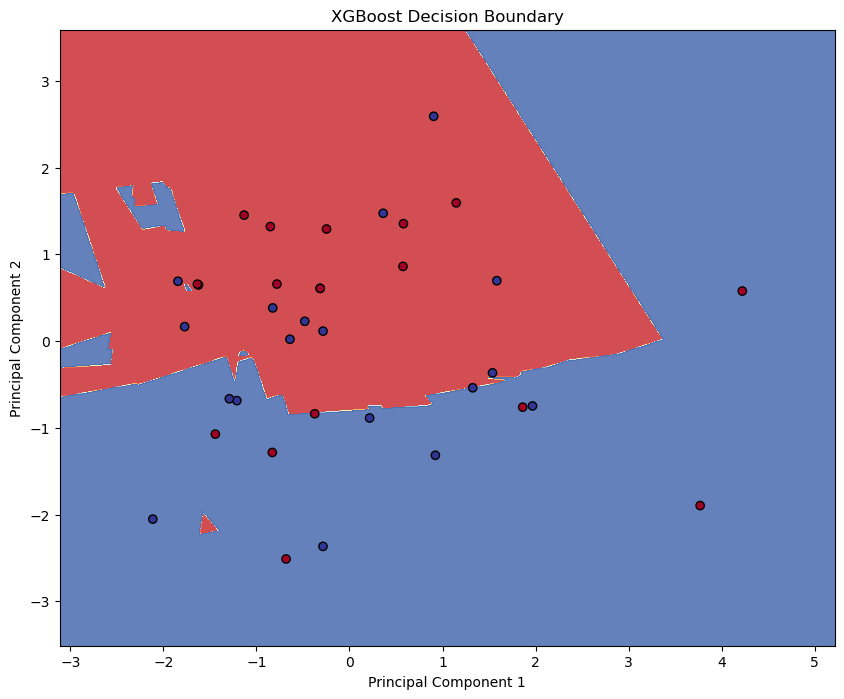

2024-11-27 17:45:34,006 [INFO] Model saved to ../../data/model/XGBoost_model.pkl
2024-11-27 17:45:34,062 [INFO] Best model based on Log Loss: XGBoost
2024-11-27 17:45:34,063 [INFO] Best Log Loss: 0.48896321231891243
2024-11-27 17:45:34,086 [INFO] Tuning results saved to '../../data/default_spl_example/tuning_results.json'.
2024-11-27 17:45:34,110 [INFO] Loading model: XGBoost
2024-11-27 17:45:35,734 [INFO] Model loaded from ../../data/model/XGBoost_model.pkl
2024-11-27 17:45:35,741 [INFO] Predictions from loaded model: [1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1]


[Debug] Initialized InversePreprocessor with assets_path: ../../data/model/pipeline/preprocessing_assets.pkl
[Debug] Starting full inverse transformation and recombination process.
[Debug] Loading pipelines and assets from: ../../data/model/pipeline/preprocessing_assets.pkl
Pipeline and assets loaded from ../../data/model/pipeline/preprocessing_assets.pkl
[Debug] Performing inverse transformation on feature groups.
Processing Feature Group: 'numerical_scaler' (Base Type: 'numerical_scaler')
Available Pipelines: ['numerical_scaler', 'numerical_minmax']
Feature Indices Keys: ['numerical_scaler', 'numerical_minmax']
Inverse transformed 'numerical_scaler' using pipeline.
Inverse Transformed Data Shape for 'numerical_scaler': (140, 5)
Feature Names: ['wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_velocity_z']
Processing Feature Group: 'numerical_minmax' (Base Type: 'numerical_minmax')
Available Pipelines: ['numerical_scaler', 'numerical_minma

In [91]:
#%%writefile ../../src/freethrow_predictions/ml/train.py
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
# from mlflow_logger import MLflowLogger
import joblib
import os
# Initialize MLflow Logger
import mlflow
import mlflow.sklearn
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Utility function to evaluate models with multiple metrics
def evaluate_model(model, X_test, y_test):
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    logger.info(f"Predictions: {y_pred}")
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Log Loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    logger.info(f"Evaluation Metrics: {metrics}")
    return metrics

# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        logger.info(f"PCA explained variance ratios: {explained_variance}")
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )
    logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")

    # Flatten the grid arrays and combine into a single array
    grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
    logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        logger.info("Inverse transforming grid points back to original feature space for prediction.")
        grid_points_original = pca.inverse_transform(grid_points_2d)
        logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
        # Predict on the grid points in original feature space
        try:
            Z = model.predict(grid_points_original)
        except ValueError as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        Z = model.predict(grid_points_original)

    Z = Z.reshape(xx.shape)
    logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
    plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
    plt.show()

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=50,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False, n_jobs=-1),
        param_space,
        n_iter=50,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=50,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_


def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    logger.info(f"Predictions: {y_pred}")
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Log Loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model and preprocessing steps to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - preprocessing_steps: Dictionary of preprocessing objects (e.g., encoders, scalers).
    - save_dir: Directory to save the model and preprocessing steps.
    """
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")

    # Save the model
    joblib.dump(model, model_path)
    logger.info(f"Model saved to {model_path}")


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model



# Main function with MLflow integration
def bayes_best_model_train(
    X_train,
    y_train,
    X_test,
    y_test,
    selection_metric="Log Loss",
    use_pca=True,
    save_dir="tuning_results.json",
    model_save_dir="../../data/model",
    selected_models=None,  # New parameter for selective training
):
    logger.info(f"X_train shape: {X_train.shape}")
    logger.info(f"y_train shape: {y_train.shape}")
    logger.info(f"X_test shape: {X_test.shape}")
    logger.info(f"y_test shape: {y_test.shape}")
    
    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Model registry mapping model names to tuner functions
    model_registry = {
        "Random Forest": tune_random_forest,
        "XGBoost": tune_xgboost,
        "Decision Tree": tune_decision_tree,
    }

    # Convert selected_models to a list if it's a string
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    
    # Normalize case for selected models and model registry
    selected_models_normalized = [model.lower() for model in selected_models]
    model_registry_normalized = {name.lower(): name for name in model_registry.keys()}

    # Filter the model registry based on normalized selected models
    valid_model_keys = [model_registry_normalized[model] for model in selected_models_normalized if model in model_registry_normalized]
    tuners_to_run = {name: model_registry[name] for name in valid_model_keys}

    # Check for invalid model names
    invalid_models = set(selected_models) - set(model_registry_normalized.keys())
    if invalid_models:
        logger.warning(f"The following models are invalid and will be ignored: {invalid_models}")
    
    # Exit if no valid models are found
    if not tuners_to_run:
        logger.error("No valid models to train. Exiting the training process.")
        return

    # Start an MLflow experiment
    mlflow.set_experiment("Model Tuning and Evaluation")
    with mlflow.start_run():
        mlflow.log_param("selection_metric", selection_metric)
        mlflow.log_param("use_pca", use_pca)
        mlflow.log_param("selected_models", selected_models)

        for model_name, tuner in tuners_to_run.items():
            logger.info(f"Tuning hyperparameters for {model_name}...")
            
            # Tune model and evaluate
            best_params, best_score, best_model_instance = tuner(X_train, y_train)
            metrics = evaluate_model(best_model_instance, X_test, y_test)
            
            # Log results to MLflow
            mlflow.log_metric(f"{model_name}_CV_Score", best_score)
            mlflow.log_metrics({f"{model_name}_{key}": value for key, value in metrics.items()})
            mlflow.log_dict(best_params, f"{model_name}_best_params.json")
            
            # Save model to MLflow
            mlflow.sklearn.log_model(best_model_instance, f"{model_name}_model")
            
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best Cross-Validation Score": best_score,
                "Evaluation Metrics": metrics,
            }
            
            logger.info(f"{model_name} Best Params: {best_params}")
            logger.info(f"{model_name} Best Cross-Validation Score: {best_score}")
            logger.info(f"{model_name} Evaluation Metrics: {metrics}")

            # Determine the best model based on the selected metric
            metric_value = metrics.get(selection_metric)
            if metric_value is not None and (
                best_metric_value is None or
                (selection_metric == "Log Loss" and metric_value < best_metric_value) or
                (selection_metric != "Log Loss" and metric_value > best_metric_value)
            ):
                best_metric_value = metric_value
                best_model_name = model_name
                best_model = best_model_instance

            # Plot decision boundary for each model
            try:
                plot_decision_boundary(
                    best_model_instance,
                    X_test,
                    y_test,
                    f"{model_name} Decision Boundary",
                    use_pca
                )
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")
        
        # Save the best model
        if best_model_name:
            save_model(
                best_model,
                model_name=best_model_name,
                save_dir=model_save_dir,
            )

        # Log the best model
        mlflow.log_param("best_model_name", best_model_name)
        mlflow.log_metric("best_metric_value", best_metric_value)

        logger.info(f"Best model based on {selection_metric}: {best_model_name}")
        logger.info(f"Best {selection_metric}: {best_metric_value}")

        with open(save_dir, "w") as f:
            json.dump(tuning_results, f, indent=4)
        mlflow.log_artifact(save_dir)
        logger.info(f"Tuning results saved to '{save_dir}'.")









if __name__ == "__main__":
    
    # from datapreprocessor_class import DataPreprocessor
    # from inverse_preprocessor_class import InversePreprocessor
    # Example 1: With train-test split
    # File paths
    features_path = '../../data/default_spl_example/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'
    category_bin_config_path = '../../data/default_spl_example/category_bin_config.pkl'

    # Example 1: With train-test split
    dp_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        category_bin_config_path=category_bin_config_path,
        y_variable='result',
        perform_split=True,
        test_size=0.2,
        random_state=123,
        stratify=True,
    )
    (
        X_train_transformed,
        X_test_transformed,
        y_train_encoded,
        y_test_encoded,
        transformed_data_train,
        transformed_train_df,  # Include the additional output
        X_train,
        y_train,
    ) = dp_split.run()


    print(f"X_train_transformed shape: {X_train_transformed.shape}")
    print(f"X_test_transformed shape: {X_test_transformed.shape}")
    print(f"Transformed Data Train: {transformed_data_train.keys()}")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")
    
    # --------------------------Best Model Bayes Optim Search------------------
    # Start hyperparameter tuning and evaluation
    logger.info("Starting hyperparameter tuning and evaluation...")
    bayes_best_model_train(
        X_train=X_train_transformed,
        y_train=y_train_encoded,
        X_test=X_test_transformed,
        y_test=y_test_encoded,
        selection_metric="Log Loss",
        use_pca=True,
        save_dir="../../data/default_spl_example/tuning_results.json",
        model_save_dir="../../data/model",
    selected_models="XGBoost",  # New parameter for selective training
    )
    
    # --------------------custom predict------------------------
    # Optionally load a pre-saved model and make predictions
    model_save_dir="../../data/model"
    load_model_name="XGBoost"
    logger.info(f"Loading model: {load_model_name}")
    loaded_model = load_model(load_model_name, save_dir=model_save_dir)
    y_pred = loaded_model.predict(X_test_transformed)
    logger.info(f"Predictions from loaded model: {y_pred}")


    # ------------Inverse transform and put y_variable_original back on-----------
    # Initialize InversePreprocessor with assets_path (no need to preload assets manually)
    inverse_transformer = InversePreprocessor(
        assets_path=assets_path,  # Assets will be loaded automatically
        debug=True
    )

    # Perform inverse transformation and combine with targets
    final_dataset = inverse_transformer.transform(
        original_data=X_train,
        transformed_data=transformed_data_train,
        y_encoded=y_train_encoded
    )

    # Display the resulting dataset
    print("[Final Dataset]:")
    print(final_dataset.head())





### Prediction Module

In [101]:
#%%writefile ../../src/freethrow_predictions/ml/predict.py

import logging

# from datapreprocessor_class import DataPreprocessor
# from inverse_preprocessor_class import InversePreprocessor
# from train import load_model  # Assuming these are defined

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)




def preprocess_data(config):
    """
    Preprocess the dataset using the DataPreprocessor class.

    :param config: Configuration dictionary with paths and parameters.
    :return: Preprocessed data.
    """
    logger.info("Initializing DataPreprocessor...")
    dp = DataPreprocessor(
        features_path=config["features_path"],
        dataset_path=config["dataset_path"],
        assets_path=config["assets_path"],
        category_bin_config_path=config["category_bin_config_path"],
        y_variable=config["y_variable"],
        perform_split=False,  # Always process the full dataset
    )
    X_transformed, y_encoded, transformed_data, transformed_data_df, X, y = dp.run()
    logger.info("Data preprocessing completed.")
    return X_transformed, y_encoded, transformed_data, transformed_data_df, X, y


def predict_with_model(X_transformed, model_name, config):
    """
    Load a pre-trained model and make predictions along with prediction probabilities.

    :param X_transformed: Transformed features for prediction.
    :param model_name: Name of the model to load.
    :param config: Configuration dictionary with paths.
    :return: Tuple of (predictions, prediction_probabilities, model)
    """
    logger.info(f"Loading model: {model_name}")
    model = load_model(model_name, save_dir=config["model_save_dir"])
    logger.info("Generating class predictions...")
    predictions = model.predict(X_transformed)
    
    logger.info("Generating prediction probabilities...")
    if hasattr(model, "predict_proba"):
        prediction_probabilities = model.predict_proba(X_transformed)
    else:
        logger.warning(f"The model '{model_name}' does not support 'predict_proba'.")
        prediction_probabilities = None

    return predictions, prediction_probabilities, model



def inverse_transform_data(X, transformed_data, y_encoded, config):
    """
    Perform inverse transformation to combine transformed and original data.

    :param X: Original features.
    :param transformed_data: Transformed features.
    :param y_encoded: Encoded labels.
    :param config: Configuration dictionary with paths.
    :return: Final dataset with inverse-transformed features.
    """
    logger.info("Performing inverse transformation...")
    inverse_transformer = InversePreprocessor(
        assets_path=config["assets_path"],
        debug=config["debug"],
    )
    final_dataset = inverse_transformer.transform(
        original_data=X,
        transformed_data=transformed_data,
        y_encoded=y_encoded,
    )
    logger.info("[Final Dataset]:")
    logger.info(final_dataset.head())
    return final_dataset


def add_predictions_to_dataset(final_dataset, predictions, y_variable):
    """
    Add predictions to the final dataset as a new column.

    :param final_dataset: DataFrame containing the final processed dataset.
    :param predictions: Array or list of predictions generated by the model.
    :param y_variable: The target variable name (used for naming the predictions column).
    :return: Updated DataFrame with predictions added as a new column.
    """
    predictions_column_name = "y_variable_prediction"
    logger.info(f"Adding predictions to the dataset as column '{predictions_column_name}'...")

    # Add predictions to the dataset
    final_dataset[predictions_column_name] = predictions

    logger.info(f"Predictions added successfully. Updated dataset preview:")
    logger.info(final_dataset.head())

    return final_dataset


def add_prediction_probabilities_to_dataset(final_dataset, prediction_probabilities, classes):
    """
    Add prediction probabilities to the final dataset as new columns.

    For binary classification, only the probability of the positive class is added.

    :param final_dataset: DataFrame containing the final processed dataset.
    :param prediction_probabilities: Array or list of prediction probabilities from the model.
    :param classes: Array of class labels corresponding to the probabilities.
    :return: Updated DataFrame with prediction probabilities added as new columns.
    """
    logger.info("Adding prediction probabilities to the dataset...")

    # Validate the shape of prediction_probabilities
    if prediction_probabilities.ndim != 2 or prediction_probabilities.shape[1] != len(classes):
        logger.error("Prediction probabilities have an unexpected shape.")
        raise ValueError("Invalid shape for prediction_probabilities.")

    if len(classes) == 2:
        # Assuming the second column is the positive class
        positive_class = classes[1]
        prob_column_name = f"y_variable_probability_class_{positive_class}"
        final_dataset[prob_column_name] = prediction_probabilities[:, 1]
        logger.info(f"Added probability column '{prob_column_name}'.")
    else:
        # For multi-class classification, add a column for each class
        for idx, class_label in enumerate(classes):
            prob_column_name = f"y_variable_probability_class_{class_label}"
            final_dataset[prob_column_name] = prediction_probabilities[:, idx]
            logger.info(f"Added probability column '{prob_column_name}'.")

    logger.info("Prediction probabilities added successfully.")
    logger.info("Updated dataset preview with probabilities:")
    logger.info(final_dataset.head())

    return final_dataset


def predict(config):
    try:
        logger.info("Starting the prediction pipeline...")

        # Step 1: Preprocess data
        X_transformed, y_encoded, transformed_data, transformed_data_df, X, y = preprocess_data(config)

        # Step 2: Make predictions and get probabilities
        predictions, prediction_probabilities, model = predict_with_model(
            X_transformed=X_transformed,
            model_name=config["selected_models"],
            config=config,
        )

        # Step 3: Inverse transformation
        final_dataset = inverse_transform_data(
            X=X,
            transformed_data=transformed_data,
            y_encoded=y_encoded,
            config=config,
        )

        # Step 4: Add predictions to the dataset
        final_dataset_with_predictions = add_predictions_to_dataset(
            final_dataset=final_dataset,
            predictions=predictions,
            y_variable=config["y_variable"],
        )

        # Step 5: Add prediction probabilities to the dataset
        if prediction_probabilities is not None:
            final_dataset_with_predictions = add_prediction_probabilities_to_dataset(
                final_dataset=final_dataset_with_predictions,
                prediction_probabilities=prediction_probabilities,
                classes=model.classes_,
            )

        logger.info("Prediction pipeline completed successfully!")
        logger.info("Final dataset with predictions is ready for use.")
        return final_dataset_with_predictions

    except Exception as e:
        logger.error(f"An error occurred: {e}", exc_info=True)
        raise



if __name__ == "__main__":
    # Configuration paths (parameterize as needed)
    predict_config = {
        "features_path": "../../data/default_spl_example/final_ml_df_selected_features_columns.pkl",
        "dataset_path": "../../data/processed/final_ml_dataset.csv",
        "assets_path": "../../data/model/pipeline/preprocessing_assets.pkl",
        "category_bin_config_path": "../../data/default_spl_example/category_bin_config.pkl",
        "model_save_dir": "../../data/model",
        "y_variable": "result",
        "selected_models": "XGBoost",
        "debug": True,
    }
    # Example usage
    final_dataset_with_predictions = predict(predict_config)
    print(final_dataset_with_predictions.head())


2024-11-27 18:07:38,275 [INFO] Starting the prediction pipeline...
2024-11-27 18:07:38,276 [INFO] Initializing DataPreprocessor...
2024-11-27 18:07:38,276 [INFO] Loading selected features...
2024-11-27 18:07:38,279 [INFO] Loading dataset...
2024-11-27 18:07:38,286 [INFO] Loading category bin configuration...
2024-11-27 18:07:38,289 [INFO] Transforming features using category bins...
2024-11-27 18:07:38,299 [INFO] Preprocessing dataset for SMOTE...
2024-11-27 18:07:38,300 [DEBUG] Identified Non-Numeric Columns:
2024-11-27 18:07:38,301 [DEBUG] ['player_participant_id', 'player_dominant_hand', 'trial_id', 'player_height_in_meters_category', 'player_weight__in_kg_category', 'player_estimated_wingspan_cm_category', 'player_estimated_standing_reach_cm_category', 'player_estimated_hand_length_cm_category']
2024-11-27 18:07:38,302 [DEBUG] Dataset Shape after dropping non-numeric columns: (125, 128)
2024-11-27 18:07:38,303 [INFO] Performing SMOTE analysis...
2024-11-27 18:07:38,304 [DEBUG] Data


Binning applied to 'player_height_in_meters' -> New column: 'player_height_in_meters_category'
   player_height_in_meters player_height_in_meters_category
0                     1.91                          Average
1                     1.91                          Average
2                     1.91                          Average
3                     1.91                          Average
4                     1.91                          Average

Binning applied to 'player_weight__in_kg' -> New column: 'player_weight__in_kg_category'
   player_weight__in_kg player_weight__in_kg_category
0                  90.7                       Average
1                  90.7                       Average
2                  90.7                       Average
3                  90.7                       Average
4                  90.7                       Average

Binning applied to 'player_estimated_wingspan_cm' -> New column: 'player_estimated_wingspan_cm_category'
   player_estimated_wing

In [ ]:
#%%writefile ../../src/freethrow_predictions/ml/bayes_optim_angles_xgboostpreds.py
import joblib
import pandas as pd
from skopt import gp_minimize
from typing import List, Dict, Tuple
import logging
from skopt.space import Real
import numpy as np

# from datapreprocessor_class import DataPreprocessor
# from inverse_preprocessor_class import InversePreprocessor
# from train import load_model  # Ensure these are correctly imported
# from predict import preprocess_data, predict_with_model, inverse_transform_data, add_predictions_to_dataset
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants (if any, e.g., default paths)
DEFAULT_SAVE_DIR = "../../data/model"
DEFAULT_PREPROCESSING_ASSETS_PATH = "../../data/model/pipeline/preprocessing_assets.pkl"
DEFAULT_OUTPUT_PATH = "../../data/new_data_with_predictions.csv"


# Function: Load model
def load_model(model_name: str, save_dir: str) -> joblib:
    """Load a trained model from the specified directory."""
    model_path = f"{save_dir}/{model_name}_model.pkl"
    return joblib.load(model_path)


# Function: Load preprocessing pipelines
def load_pipeline(preprocessing_assets_path: str) -> Dict:
    """Load preprocessing pipelines from a given path."""
    return joblib.load(preprocessing_assets_path)


def predict(
    model_name,
    dataset,
    y_variable,
    numerical_info_df,
    categorical_info_df,
    preprocessing_assets_path="../../data/model/pipeline/preprocessing_assets.pkl",
    save_dir="../../data/model",
    output_path="../../data/new_data_with_predictions.csv",
    debug=False
):
    """
    Automated prediction pipeline that preprocesses data, makes predictions, 
    and saves the output with inverse-transformed features.

    Parameters:
    - model_name: Name of the trained model to use for predictions.
    - dataset: DataFrame of the dataset for prediction.
    - y_variable: Target variable name.
    - numerical_info_df: DataFrame containing numerical feature metadata.
    - categorical_info_df: DataFrame containing categorical feature metadata.
    - preprocessing_assets_path: Path to preprocessing pipelines.
    - save_dir: Directory where the model and pipelines are saved.
    - output_path: Path to save the output with predictions.
    - debug: Boolean flag for debugging information.

    Returns:
    - DataFrame: DataFrame with predictions and inverse-transformed features.
    """
    # Load the model and preprocessing assets
    model = load_model(model_name, save_dir)
    fitted_pipelines = load_pipeline(preprocessing_assets_path)

    # Extract features and filter them
    print("\n[Feature Filtering]")
    (
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
    ) = filter_features(
        numerical_info_df, categorical_info_df, dataset, y_variable, debug=debug
    )

    original_feature_names = {
        'numerical_scaler': numerical_scaler_features,
        'numerical_minmax': numerical_minmax_features,
        'numerical_kbins': numerical_kbins_features,
        'numerical_dimred': numerical_dimred_features,
        'onehot': onehot_features,
        'labelencode': labelencode_features,
        'unprocessed': unprocessed_features,
    }

    # Split into features (X) and target (y)
    X = dataset.drop(columns=[y_variable])
    y = dataset[y_variable]

    # Preprocess the new data
    transformed_data, _, feature_indices = process_feature_groups(
        X,
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
        fitted_pipelines=fitted_pipelines,
        debug=debug
    )
    print("Preprocessing", "key_feature=", list(transformed_data.keys())[0])

    # Combine transformed features
    X_transformed = combine_transformed_data_with_index(transformed_data, feature_indices, X.index)
    print("Combine Transformed Features", "key_feature=", X_transformed.columns[0],"X_transformed shape =", X_transformed.shape)

    # Make predictions
    predictions = model.predict(X_transformed)
    print("Predictions", predictions, "key_feature=", 0,"predictions shape =", predictions.shape)
    probabilities_class1 = model.predict_proba(X_transformed)[:, 1]
    print("probabilities_class1", probabilities_class1, "key_feature=", 0,"predictions shape =", probabilities_class1.shape)
    # Decode predictions if label encoder is available
    label_encoder = fitted_pipelines.get('label_encoder', None)
    if label_encoder:
        predictions_decoded = label_encoder.inverse_transform(predictions)
    else:
        predictions_decoded = predictions
    print("Decode Predictions", predictions_decoded, "key_feature=", 0,"predictions_decoded shape =", predictions_decoded.shape)

    # Inverse transform the data
    inverse_transformed_data = inverse_transform_feature_groups(
        transformed_data,
        fitted_pipelines,
        feature_indices,
        debug=debug
    )
    print("Inverse Transform Features", "key_feature=", list(inverse_transformed_data.keys())[0])

    # Combine inverse transformed data
    X_inverse_transformed = combine_inverse_transformed_data(
        inverse_transformed_data,
        X.index,       # Original index
        X.columns,     # Original columns
        debug=True
    )

    print("Combine Inverse Transformed Features", "key_feature=", X_inverse_transformed.columns[0],"inverse_transformed_data shape =", X_inverse_transformed.shape)

    # Prepare final dataset with original target variable
    if label_encoder:
        y_decoded = label_encoder.inverse_transform(y)
    else:
        y_decoded = y

    # Ensure indices match
    if not X_inverse_transformed.index.equals(y.index):
        raise ValueError("Index mismatch between X_inverse_transformed and y")

    X_with_target = prepare_final_dataset_with_target(
        X, X_inverse_transformed, y, y_decoded, debug=debug
    )
    print("Final Dataset with Target", "key_feature=", X_with_target.columns[0])

    # Append predictions to the final dataset
    X_with_target['y_variable_predictions'] = predictions_decoded

    # Save the output to a CSV
    X_with_target.to_csv(output_path, index=False)
    if debug:
        print(f"Predictions saved to {output_path}")
        print(X_with_target.head())

    return X_with_target


# Function: Create base DataFrame
def create_base_df(dataset: pd.DataFrame, angle_columns: List[str]) -> pd.DataFrame:
    """
    Create a base DataFrame with mean values for numerical features 
    and mode values for categorical features.
    """
    mean_values = dataset[angle_columns].mean()
    return pd.DataFrame([mean_values])



# Function: Objective function for Bayesian optimization
def objective_function(
    angles: List[float],
    base_df: pd.DataFrame,
    numerical_scaler_features: List[str],
    numerical_minmax_features: List[str],
    numerical_kbins_features: List[str],
    numerical_dimred_features: List[str],
    onehot_features: List[str],
    labelencode_features: List[str],
    unprocessed_features: List[str],
    fitted_pipelines: Dict,
    model: joblib,
) -> float:
    """
    Objective function for Bayesian optimization.
    Updates the angle columns and predicts the probability of class 1.
    """
    # Copy base DataFrame
    X_new = base_df.copy()
    X_new["Elbow Release Angle"], X_new["Wrist Release Angle"], X_new["Knee Release Angle"] = angles

    # Debug: Log the shape and updated angles
    print("[Debug] X_new Shape:", X_new.shape)
    print("[Debug] Updated Angles in X_new:",
          X_new[["Elbow Release Angle", "Wrist Release Angle", "Knee Release Angle"]].iloc[0].to_dict())

    # Preprocess X_new
    transformed_data, _, feature_indices = process_feature_groups(
        X_new,
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
        fitted_pipelines=fitted_pipelines,
        debug=False,
    )

    # Debug: Log keys and a sample transformed feature
    print("[Debug] Transformed Data Keys:", list(transformed_data.keys()))
    first_key = list(transformed_data.keys())[0]
    print(f"[Debug] Transformed Data Sample ({first_key}):", transformed_data[first_key][:5])

    # Combine transformed features
    X_transformed = combine_transformed_data_with_index(transformed_data, feature_indices, X_new.index)

    # Debug: Log shape of X_transformed
    print("[Debug] X_transformed Shape:", X_transformed.shape)

    # Predict probabilities
    probabilities = model.predict_proba(X_transformed)

    # Debug: Log probabilities
    print("[Debug] Prediction Probabilities:", probabilities)

    # Return negative probability of class 1
    return -probabilities[0, 1]





if __name__ == "__main__":
    # Load dataset and metadata
    dataset = final_ml_df_selected_features.copy()
    y_variable = "result"
    angle_columns = [
        "elbow_release_angle", "elbow_max_angle", "wrist_release_angle", "wrist_max_angle",
        "knee_release_angle", "knee_max_angle", "release_ball_velocity_z", 'release_ball_direction_x', 
        'release_ball_direction_z', 'release_ball_direction_y', 'release_angle', 'release_ball_speed', 'release_ball_velocity_x', 'release_ball_velocity_y'
    ]

    # Create base DataFrame
    base_df = create_base_df(dataset, angle_columns)
    print("Base DataFrame for optimization:")
    print(base_df)

    # Load model and preprocessing pipelines
    model_name = "XGBoost"
    model = load_model(model_name, DEFAULT_SAVE_DIR)
    fitted_pipelines = load_pipeline(DEFAULT_PREPROCESSING_ASSETS_PATH)

    # Filter features
    (
        numerical_scaler_features,
        numerical_minmax_features,
        numerical_kbins_features,
        numerical_dimred_features,
        onehot_features,
        labelencode_features,
        unprocessed_features,
    ) = filter_features(numerical_info_df, categorical_info_df, dataset, y_variable, debug=True)

    # Test Model Sensitivity
    test_angles = [
        (30, 0, 30),  # Minimum boundary
        (150, 90, 150),  # Maximum boundary
        (90, 45, 90),  # Midpoint
    ]
    for angles in test_angles:
        prob = objective_function(
            angles,
            base_df,
            numerical_scaler_features,
            numerical_minmax_features,
            numerical_kbins_features,
            numerical_dimred_features,
            onehot_features,
            labelencode_features,
            unprocessed_features,
            fitted_pipelines,
            model,
        )
        print(f"[Test] Angles: {angles}, Probability: {-prob}")

    # Run Bayesian optimization
    result = gp_minimize(
        func=lambda angles: objective_function(
            angles,
            base_df,
            numerical_scaler_features,
            numerical_minmax_features,
            numerical_kbins_features,
            numerical_dimred_features,
            onehot_features,
            labelencode_features,
            unprocessed_features,
            fitted_pipelines,
            model,
        ),
        dimensions=[
            (30, 150),  # Elbow Release Angle
            (0, 90),    # Wrist Release Angle
            (30, 150),  # Knee Release Angle
        ],
        n_calls=50,
        n_random_starts=10,
        verbose=True,
    )

    # Display Results
    print("Optimal angles:")
    print("Elbow Release Angle:", result.x[0])
    print("Wrist Release Angle:", result.x[1])
    print("Knee Release Angle:", result.x[2])
    print("Maximum probability of y_variable_prediction=1:", -result.fun)




Base DataFrame for optimization:
   elbow_release_angle  elbow_max_angle  wrist_release_angle  wrist_max_angle  \
0            65.392353       104.156902            27.069265        38.320729   

   knee_release_angle  knee_max_angle  release_ball_velocity_z  \
0           30.633745       62.044712                  9.33169   

   release_ball_direction_x  release_ball_direction_z  \
0                  0.343687                   0.92693   

   release_ball_direction_y  release_angle  release_ball_speed  \
0                 -0.065802      68.612186           10.124215   

   release_ball_velocity_x  release_ball_velocity_y  
0                  3.65461                -0.629099  
[Debug] Dataset Features: {'wrist_release_angle', 'wrist_max_angle', 'release_ball_direction_z', 'release_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'release_ball_speed', 'release_ball_direction_x', 'elbow_max_angle', 'release_ba

/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [34, 1, 150] before, using random point [109, 73, 35]
  warnings.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.2851
Function value obtained: -0.7632
Current minimum: -0.7632
Iteration No: 43 started. Searching for the next optimal point.
[Debug] X_new Shape: (1, 17)
[Debug] Updated Angles in X_new: {'Elbow Release Angle': 34, 'Wrist Release Angle': 1, 'Knee Release Angle': 149}
[Debug] Transformed Data Keys: ['numerical_scaler', 'numerical_minmax', 'unprocessed']
[Debug] Transformed Data Sample (numerical_scaler): [[0. 0. 0. 0. 0.]]
[Debug] X_transformed Shape: (1, 14)
[Debug] Prediction Probabilities: [[0.23681349 0.7631865 ]]
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.2816
Function value obtained: -0.7632
Current minimum: -0.7632
Iteration No: 44 started. Searching for the next optimal point.
[Debug] X_new Shape: (1, 17)
[Debug] Updated Angles in X_new: {'Elbow Release Angle': 30, 'Wrist Release Angle': 3, 'Knee Release Angle': 31}
[Debug] Transformed Data Keys: ['numerical

In [104]:
print(y_test.value_counts())  # For binary classification
print(X_test.describe())  # Check for anomalies or inconsistent scaling.

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


from sklearn.calibration import calibration_curve
prob_pos = model.predict_proba(X_test_transformed)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
print("prob_pos =", prob_pos)
print(fraction_of_positives, mean_predicted_value)


result
0    18
1    18
Name: count, dtype: int64
       wrist_release_angle  wrist_max_angle  release_angle  \
count            36.000000        36.000000      36.000000   
mean             27.254631        39.093305      68.218414   
std               3.394930         2.780690       5.570158   
min              22.322812        32.709741      59.257535   
25%              24.326111        37.013739      63.913575   
50%              26.538665        39.192456      67.106948   
75%              28.853099        40.802524      72.328467   
max              34.506270        44.336922      82.690336   

       release_ball_direction_z  knee_release_angle  knee_max_angle  \
count                 36.000000           36.000000       36.000000   
mean                   0.924166           30.203321       61.749685   
std                    0.033328            2.850394        2.130834   
min                    0.859474           24.229610       56.807056   
25%                    0.898127      

ValueError: Found input variables with inconsistent numbers of samples: [36, 53]

### Feature Importance Re-examination: Shap/RandomF

In [ ]:
#%%writefile ../../src/freethrow_predictions/ml/shap_values.py


#Links: https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
#



import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Initialize SHAP
shap.initjs()

# Function to load the trained model
def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = f"{save_dir}/{model_name}_model.pkl"
    model = joblib.load(model_path)
    print(f"Model loaded from {model_path}")
    return model

# Function to compute SHAP values
def compute_shap_values(model, X_test):
    """
    Compute SHAP values for the test data with debugging for SHAP values structure.
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    # Debugging SHAP values
    print(f"SHAP values type: {type(shap_values)}")
    print(f"SHAP values shape: {shap_values.values.shape}")
    print(f"X_test shape: {X_test.shape}")

    if isinstance(shap_values.values, np.ndarray) and shap_values.values.ndim == 3:
        print(f"Multi-class output detected with {shap_values.values.shape[1]} classes.")
    elif isinstance(shap_values.values, np.ndarray):
        print("Binary or single-class output detected.")
    else:
        raise ValueError("Unexpected SHAP values format.")

    # Ensure alignment
    if shap_values.values.shape[0] != X_test.shape[0]:
        raise ValueError("Mismatch between SHAP values rows and X_test rows.")

    print("SHAP values computed.")
    return explainer, shap_values

def plot_class_summary(shap_values, X_test, num_classes):
    """
    Plot SHAP summary plot for each class in multi-class output.
    """
    for label in range(num_classes):
        print(f"Generating summary plot for class {label}...")
        shap.summary_plot(shap_values.values[:, label, :], X_test)
        plt.show()


# Visualization functions
def plot_summary(shap_values, X_test, label=None):
    """
    Plot SHAP summary plot.

    Parameters:
    - shap_values: SHAP values.
    - X_test: Test dataset (features only).
    - label: Specific class label to plot (optional).
    """
    if label is not None:
        shap.summary_plot(shap_values[label], X_test)
    else:
        shap.summary_plot(shap_values, X_test)

def plot_dependence(feature, shap_values, X_test, interaction_index=None):
    """
    Plot SHAP dependence plot.

    Parameters:
    - feature: Feature to plot.
    - shap_values: SHAP values (Explanation object).
    - X_test: Test dataset (features only).
    - interaction_index: Feature to show interactions with (optional).
    """
    try:
        # Extract values for plotting
        shap.dependence_plot(
            feature,
            shap_values.values,  # Correct access of SHAP values
            X_test,
            interaction_index=interaction_index
        )
        plt.show()
    except Exception as e:
        print(f"Error generating dependence plot for {feature}: {e}")



def plot_force(explainer, shap_values, X_test, index):
    """
    Plot SHAP force plot for a specific instance.

    Parameters:
    - explainer: SHAP Explainer object.
    - shap_values: SHAP values (Explanation object).
    - X_test: Test dataset (features only).
    - index: Index of the test instance to explain.
    """
    try:
        # Handle binary or single-class outputs
        shap.plots.force(
            base_value=explainer.expected_value,
            shap_values=shap_values.values[index],
            features=X_test.iloc[index, :],
            matplotlib=True
        )
        plt.show()
    except Exception as e:
        print(f"Error generating force plot: {e}")

        

def plot_force_for_classes(explainer, shap_values, X_test, index):
    """
    Generate force plots for each class.

    Parameters:
    - explainer: SHAP Explainer object.
    - shap_values: SHAP values (Explanation object).
    - X_test: Test dataset (features only).
    - index: Index of the test instance to explain.
    """
    try:
        num_classes = shap_values.values.shape[1] if shap_values.values.ndim == 3 else 1
        for label in range(num_classes):
            print(f"Generating force plot for class {label}, instance {index}...")
            shap.plots.force(
                base_value=explainer.expected_value[label] if num_classes > 1 else explainer.expected_value,
                shap_values=shap_values.values[index, label, :] if num_classes > 1 else shap_values.values[index],
                features=X_test.iloc[index, :],
                matplotlib=True
            )
            plt.show()
    except Exception as e:
        print(f"Error generating force plot for class {label}: {e}")



def plot_decision(explainer, shap_values, X_test):
    """
    Plot SHAP decision plot.

    Parameters:
    - explainer: SHAP Explainer object.
    - shap_values: SHAP values (Explanation object).
    - X_test: Test dataset (features only).
    """
    try:
        feature_names = X_test.columns.tolist() if hasattr(X_test, "columns") else list(range(X_test.shape[1]))
        shap.decision_plot(
            base_value=explainer.expected_value,
            shap_values=shap_values.values,
            feature_names=feature_names
        )
        plt.show()
    except Exception as e:
        print(f"Error generating decision plot: {e}")


def shap_analysis(
    model_name,
    save_dir,
    X_test,
    features_to_plot=None,
    save_plots=False,
    output_dir="./shap_outputs"
):
    """
    Perform SHAP analysis and generate plots for binary/multi-class output.
    """
    # Load the model
    model = load_model(model_name, save_dir)

    # Compute SHAP values
    explainer, shap_values = compute_shap_values(model, X_test)

    # Create output directory if saving plots
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)

    # Summary Plot
    print("Generating summary plot...")
    try:
        shap.summary_plot(shap_values.values, X_test)
        plt.show()
        if save_plots:
            plt.savefig(f"{output_dir}/summary_plot.png")
    except Exception as e:
        print(f"Error generating summary plot: {e}")

    # Dependence Plots
    if features_to_plot:
        for feature in features_to_plot:
            print(f"Generating dependence plot for {feature}...")
            try:
                plot_dependence(feature, shap_values, X_test)
                plt.show()
                if save_plots:
                    plt.savefig(f"{output_dir}/{feature}_dependence_plot.png")
            except Exception as e:
                print(f"Error generating dependence plot for {feature}: {e}")

    # Force Plot for First Instance
    print("Generating force plot for the first instance...")
    try:
        plot_force_for_classes(explainer, shap_values, X_test, index=0)
    except Exception as e:
        print(f"Error generating force plots: {e}")

    # Decision Plot
    print("Generating decision plot...")
    try:
        plot_decision(explainer, shap_values, X_test)
    except Exception as e:
        print(f"Error generating decision plot: {e}")

    print("SHAP analysis completed.")


if __name__ == "__main__":
    # Example Test Data
    # load in x_test, preprocess into x_transformed
    
    # Test SHAP analysis
    shap_analysis(
        model_name="XGBoost",
        save_dir="../../data/model",
        X_test=X_test,
        features_to_plot=["knee_release_angle", "release_angle", "elbow_release_angle"],
        save_plots=True,
        output_dir="../../data/model/shap/"
    )
    
